This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working model. 

The complete evaluation script can be found in the root directory of the repository `eval_iter.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')

# Adjusting global plotting parameters
plt.rcParams['font.size'] = 26        # Adjusts the main font size
plt.rcParams['axes.labelsize'] = 26   # Font size of x and y labels
plt.rcParams['xtick.labelsize'] = 26  # Font size of numbers on x-axis
plt.rcParams['ytick.labelsize'] = 26  # Font size of numbers on y-axis
plt.rcParams['legend.fontsize'] = 26  # Font size of legend

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42
/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overall benchmark

In [3]:
metrics = ['rmse', 'bias', 'ssim', 'sdiv']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$10^{-3}kg kg^{-1}$'})
linecolors = ['black', '#1f77b4', '#ff7f0e', '#2ca02c', 'red']

First, we plot all centers

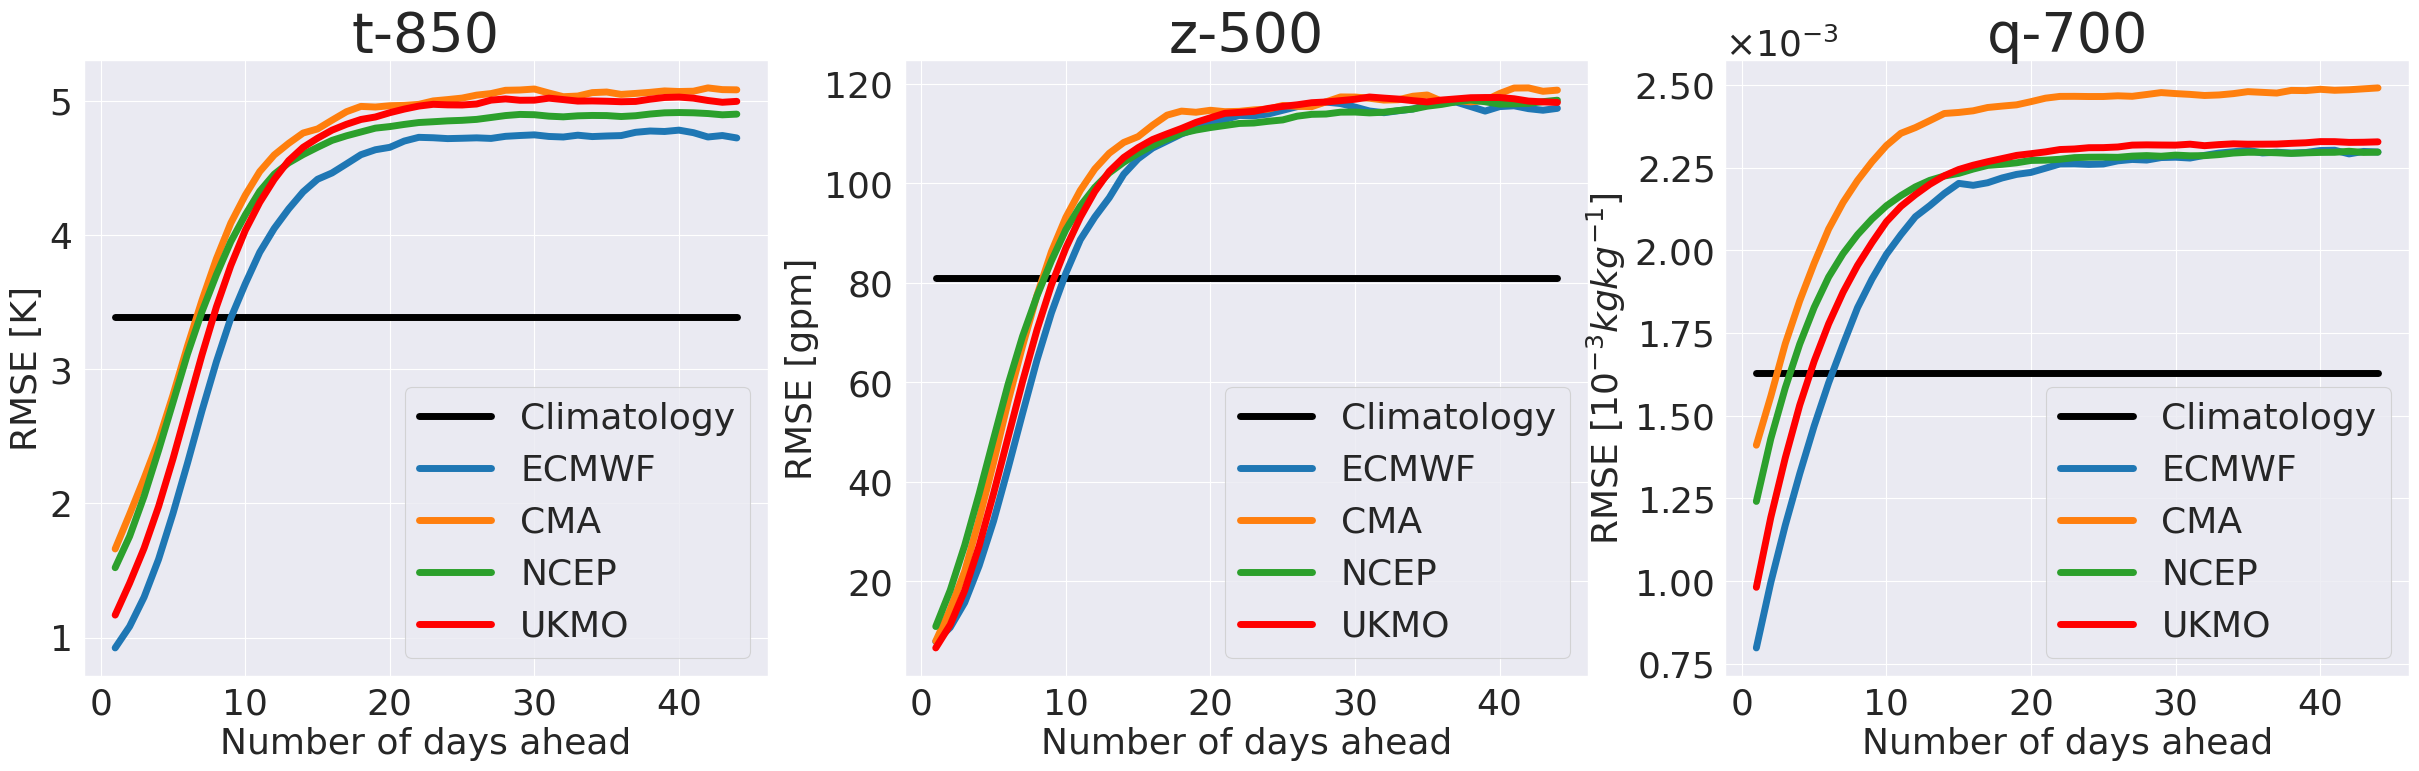

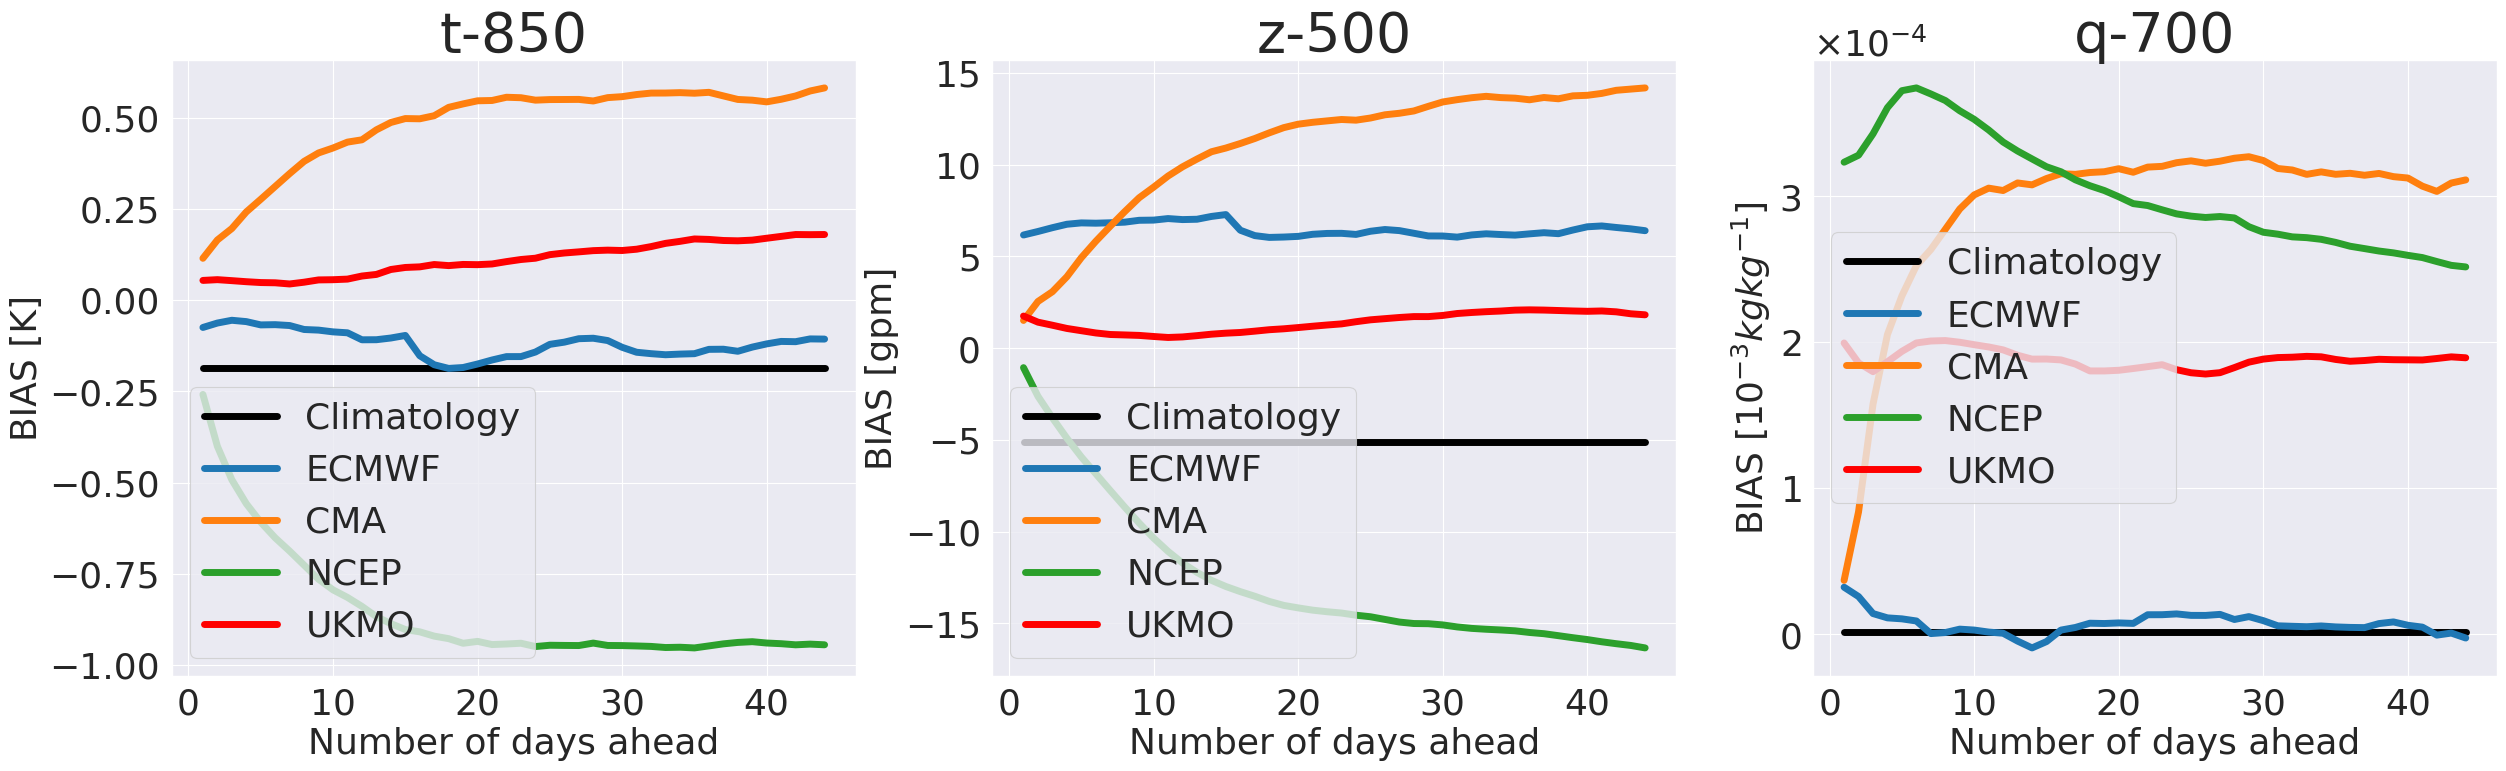

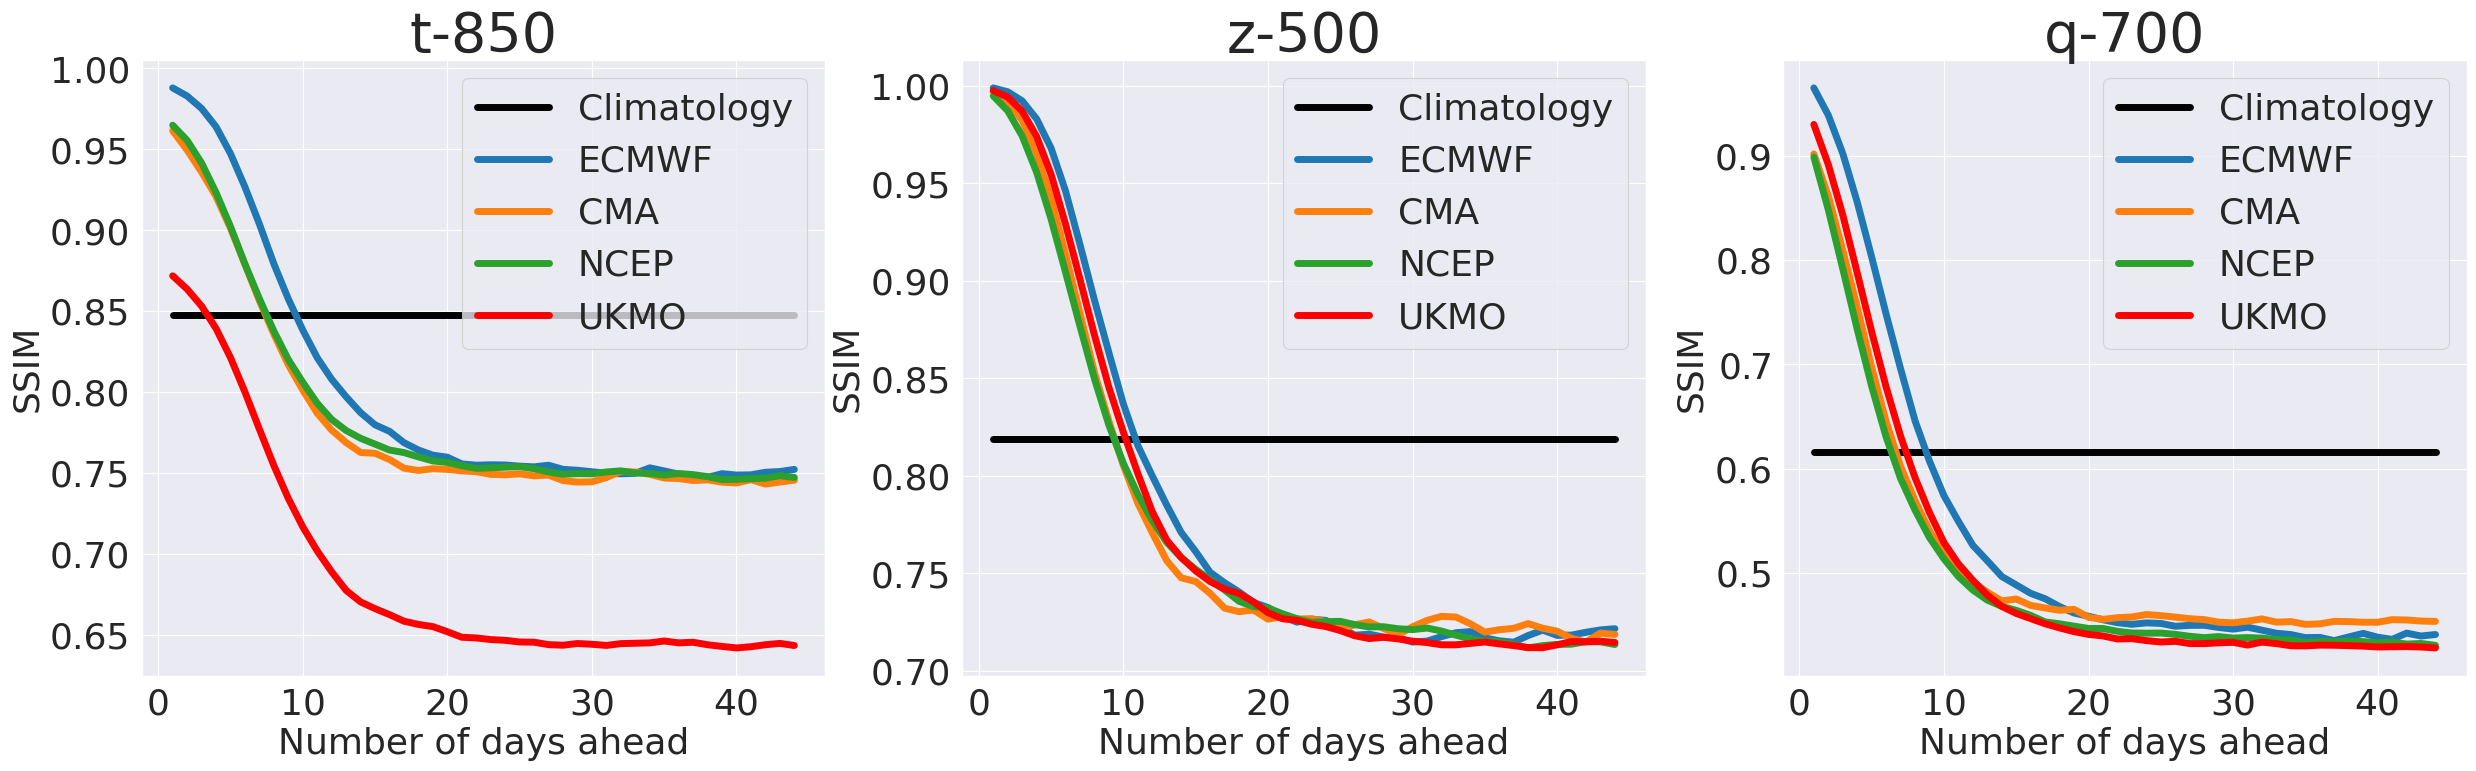

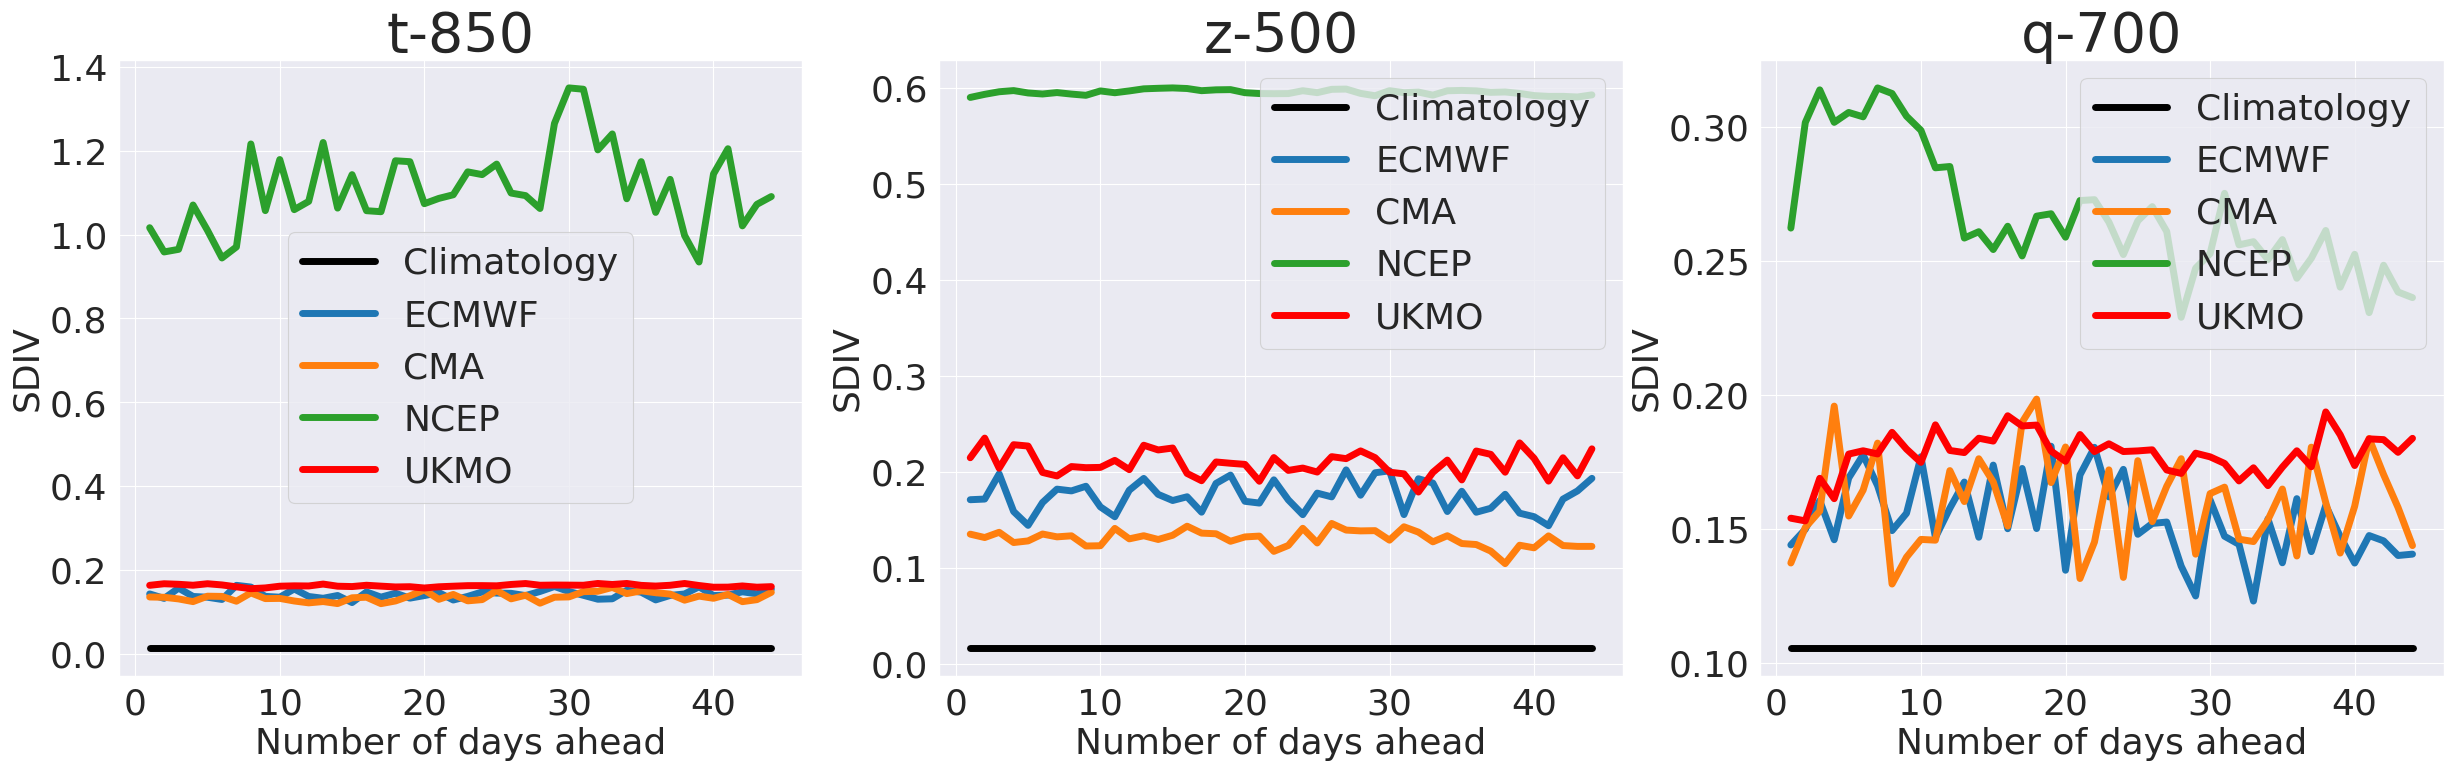

In [5]:
# Plot RMSE over time, across centers
model_names = ['climatology', 'ecmwf', 'cma', 'ncep', 'ukmo']
labels = ['Climatology', 'ECMWF', 'CMA', 'NCEP', 'UKMO']

for metric_idx, metric in enumerate(metrics):
    f, ax = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 8))
    
    for model_idx, model_name in enumerate(model_names):
        df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            
            try:
                y = df[[headline_var]].to_numpy().squeeze()
                
                # Handling imputation of NaN values with 0.0
                if y.mean() == 0.0:
                    continue
                    
                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=labels[model_idx],
                    linewidth=5,
                    color=linecolors[model_idx],
                    ax=ax[headline_idx]
                )
            except:
                pass
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            
            if metric in ['acc', 'ssim', 'sdiv']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}', fontsize=40)
            
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))  # Adjust the range for scientific notation
        plt.gca().yaxis.set_major_formatter(formatter)        
            
    plt.show();
    f.savefig(f'../docs/all_{metric}_centers.pdf', dpi=200, bbox_inches='tight');


Next, we plot results for climatology and SoTA

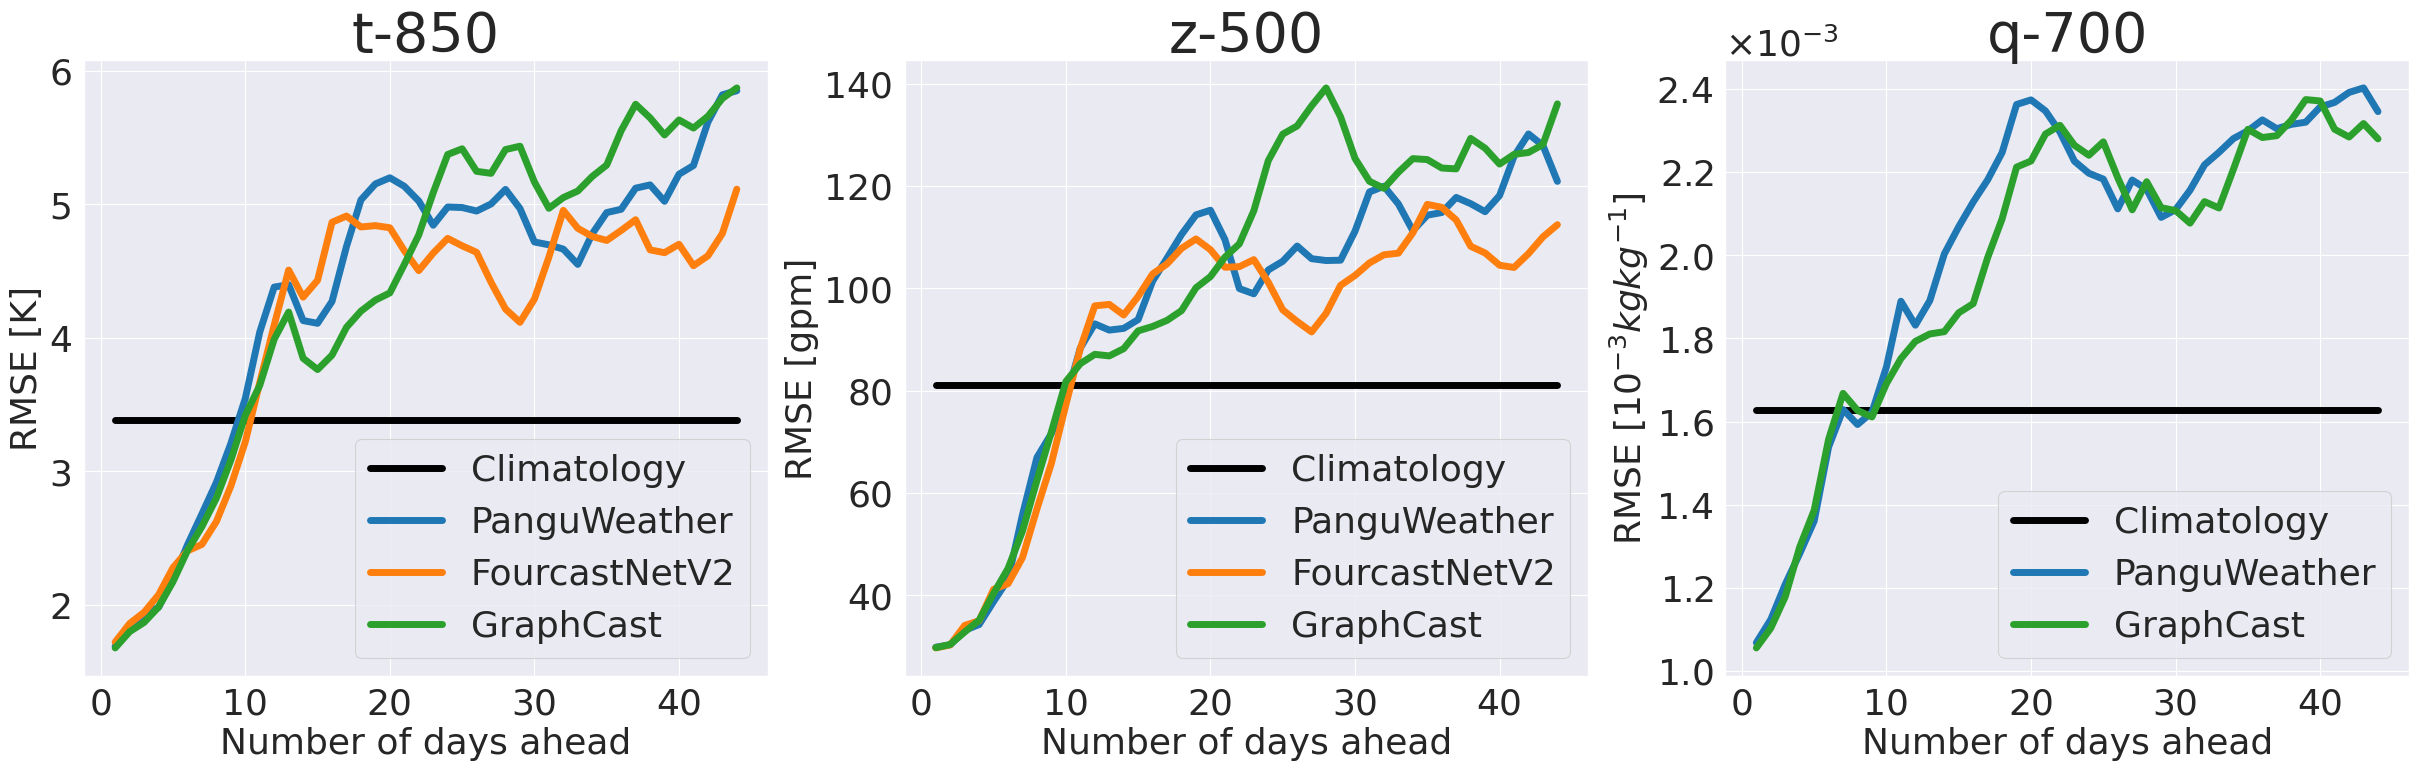

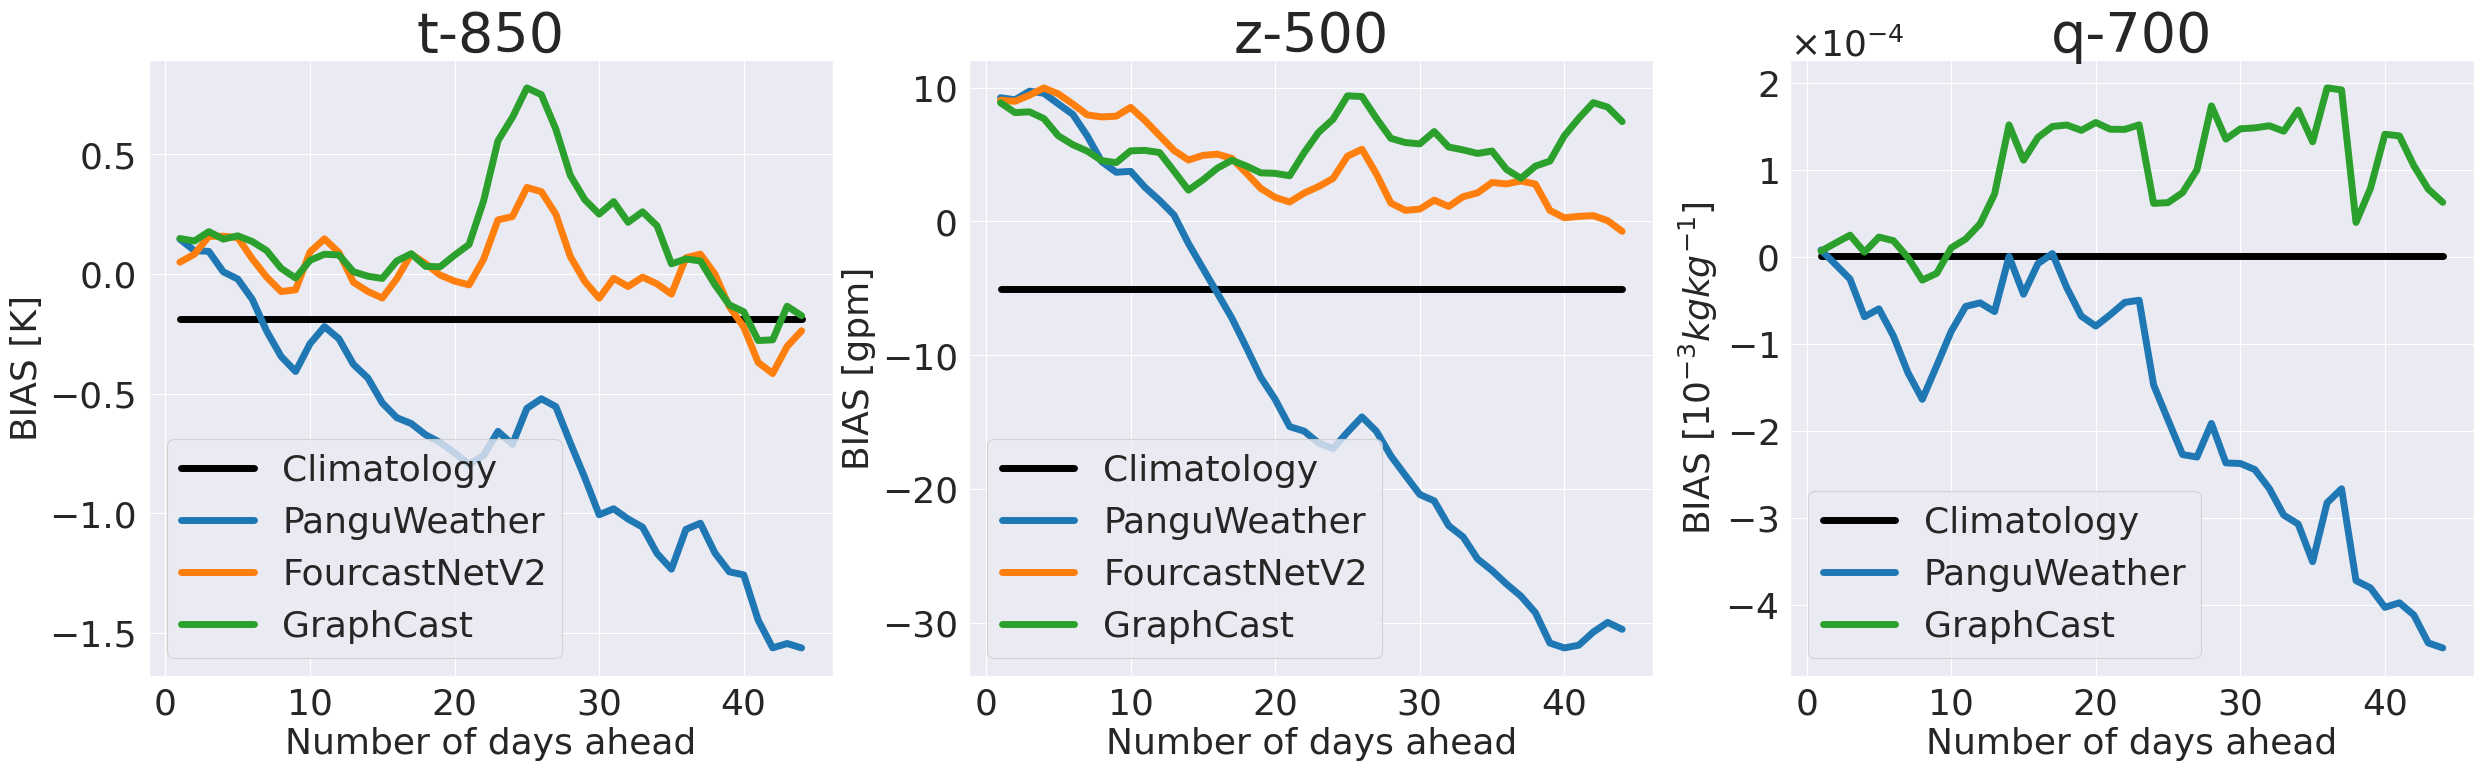

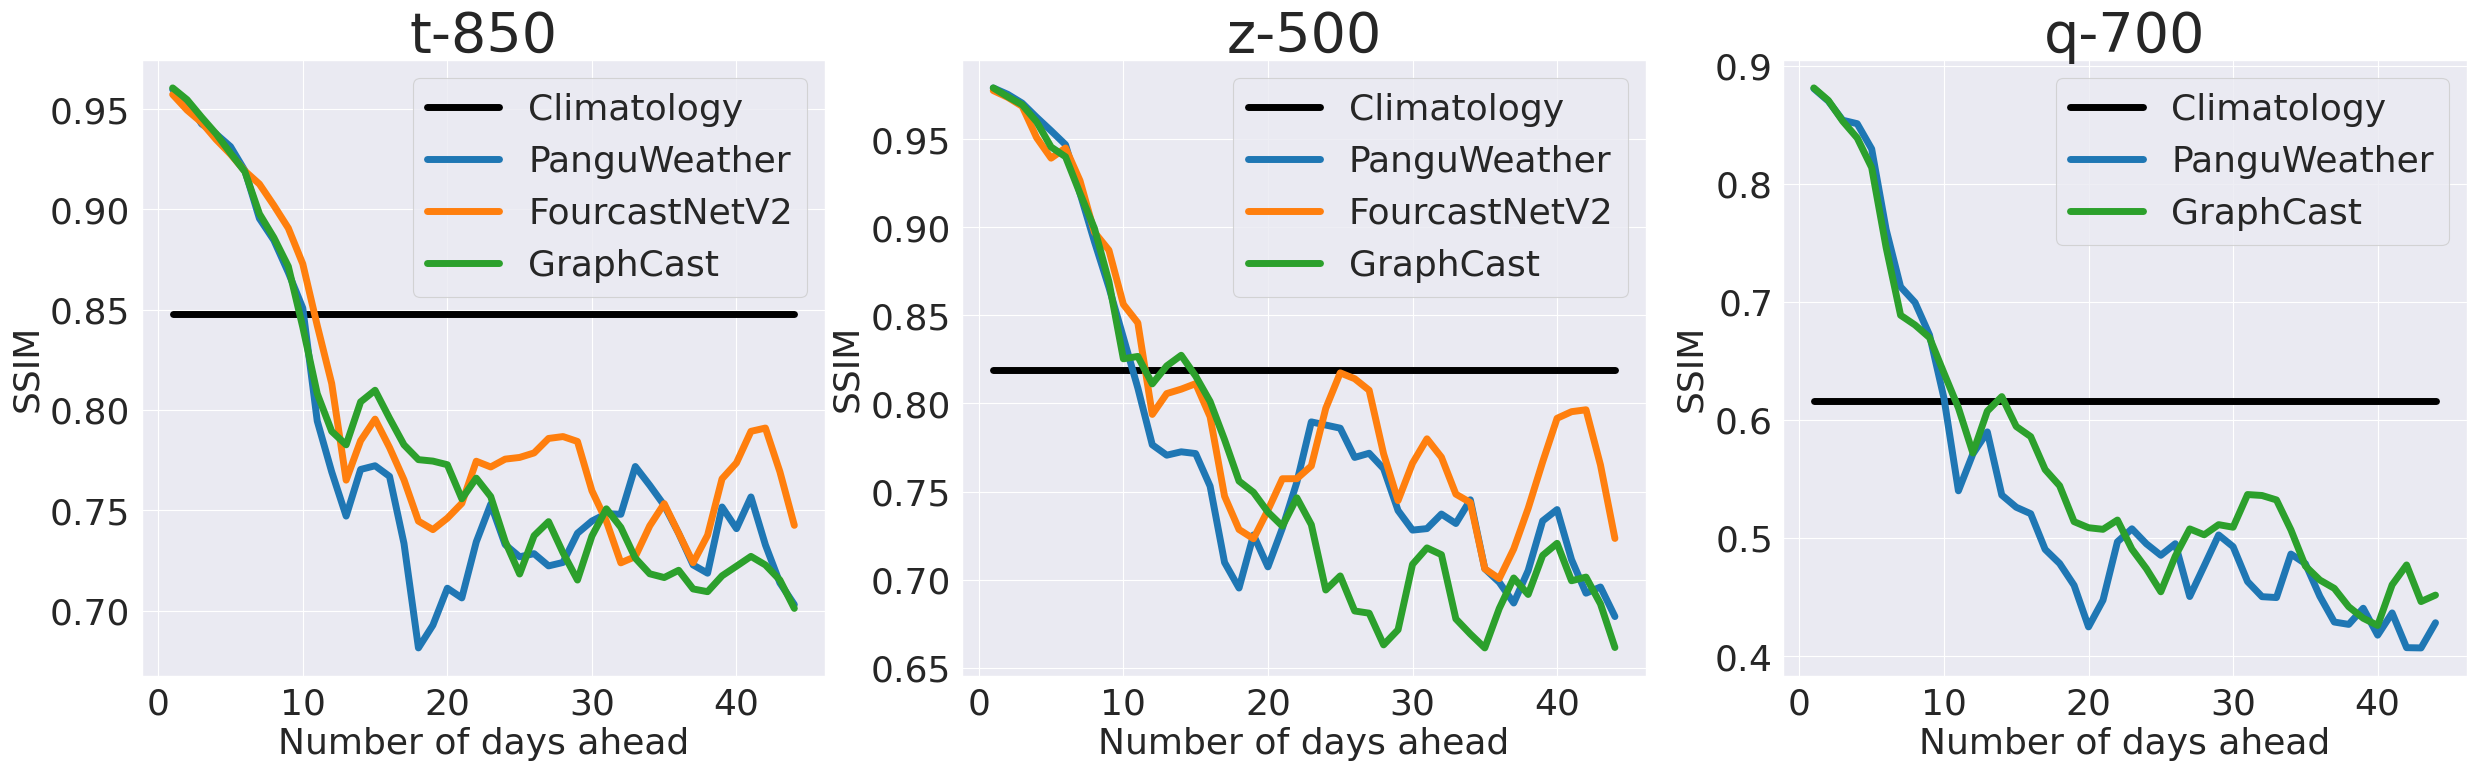

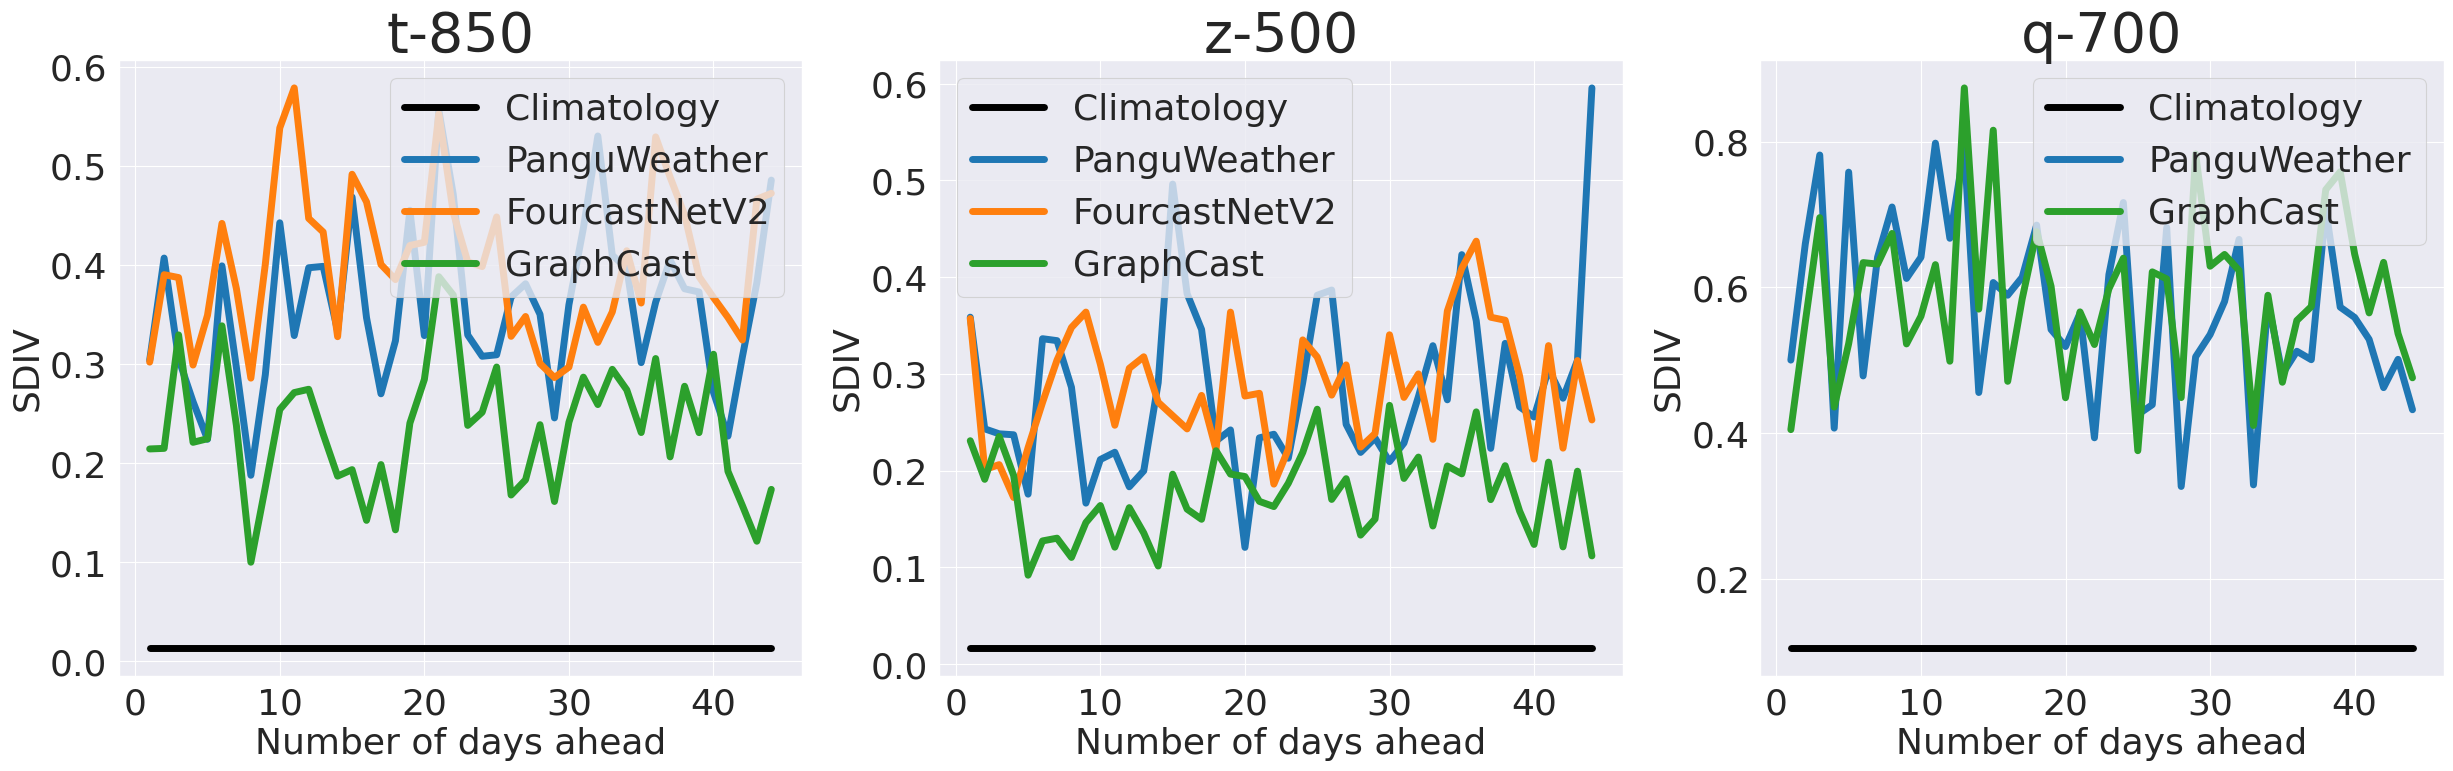

In [7]:
# Plot metrics over time, across SoTa
model_names = ['climatology', 'panguweather', 'fourcastnetv2', 'graphcast']
labels = ['Climatology', 'PanguWeather', 'FourcastNetV2', 'GraphCast']

for metric_idx, metric in enumerate(metrics):
    f, ax = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 8))
    
    for model_idx, model_name in enumerate(model_names):
        if 'climax' in model_name or 's2s' in model_name:
            model_basename, model_task = model_name.split('/')
            df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{model_task}/{metric}_{model_basename}.csv'))
        
        else:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            
            try:
                y = df[[headline_var]].to_numpy().squeeze()
                
                # Handling imputation of NaN values with 0.0
                if y.mean() == 0.0:
                    continue
                    
                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=labels[model_idx],
                    linewidth=5,
                    color=linecolors[model_idx],
                    ax=ax[headline_idx]
                )
            except:
                pass
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            
            if metric in ['acc', 'ssim', 'sdiv']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}', fontsize=40)
            
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))  # Adjust the range for scientific notation
        plt.gca().yaxis.set_major_formatter(formatter)        
            
    plt.show();
    f.savefig(f'../docs/all_{metric}_sota.pdf', dpi=200, bbox_inches='tight');


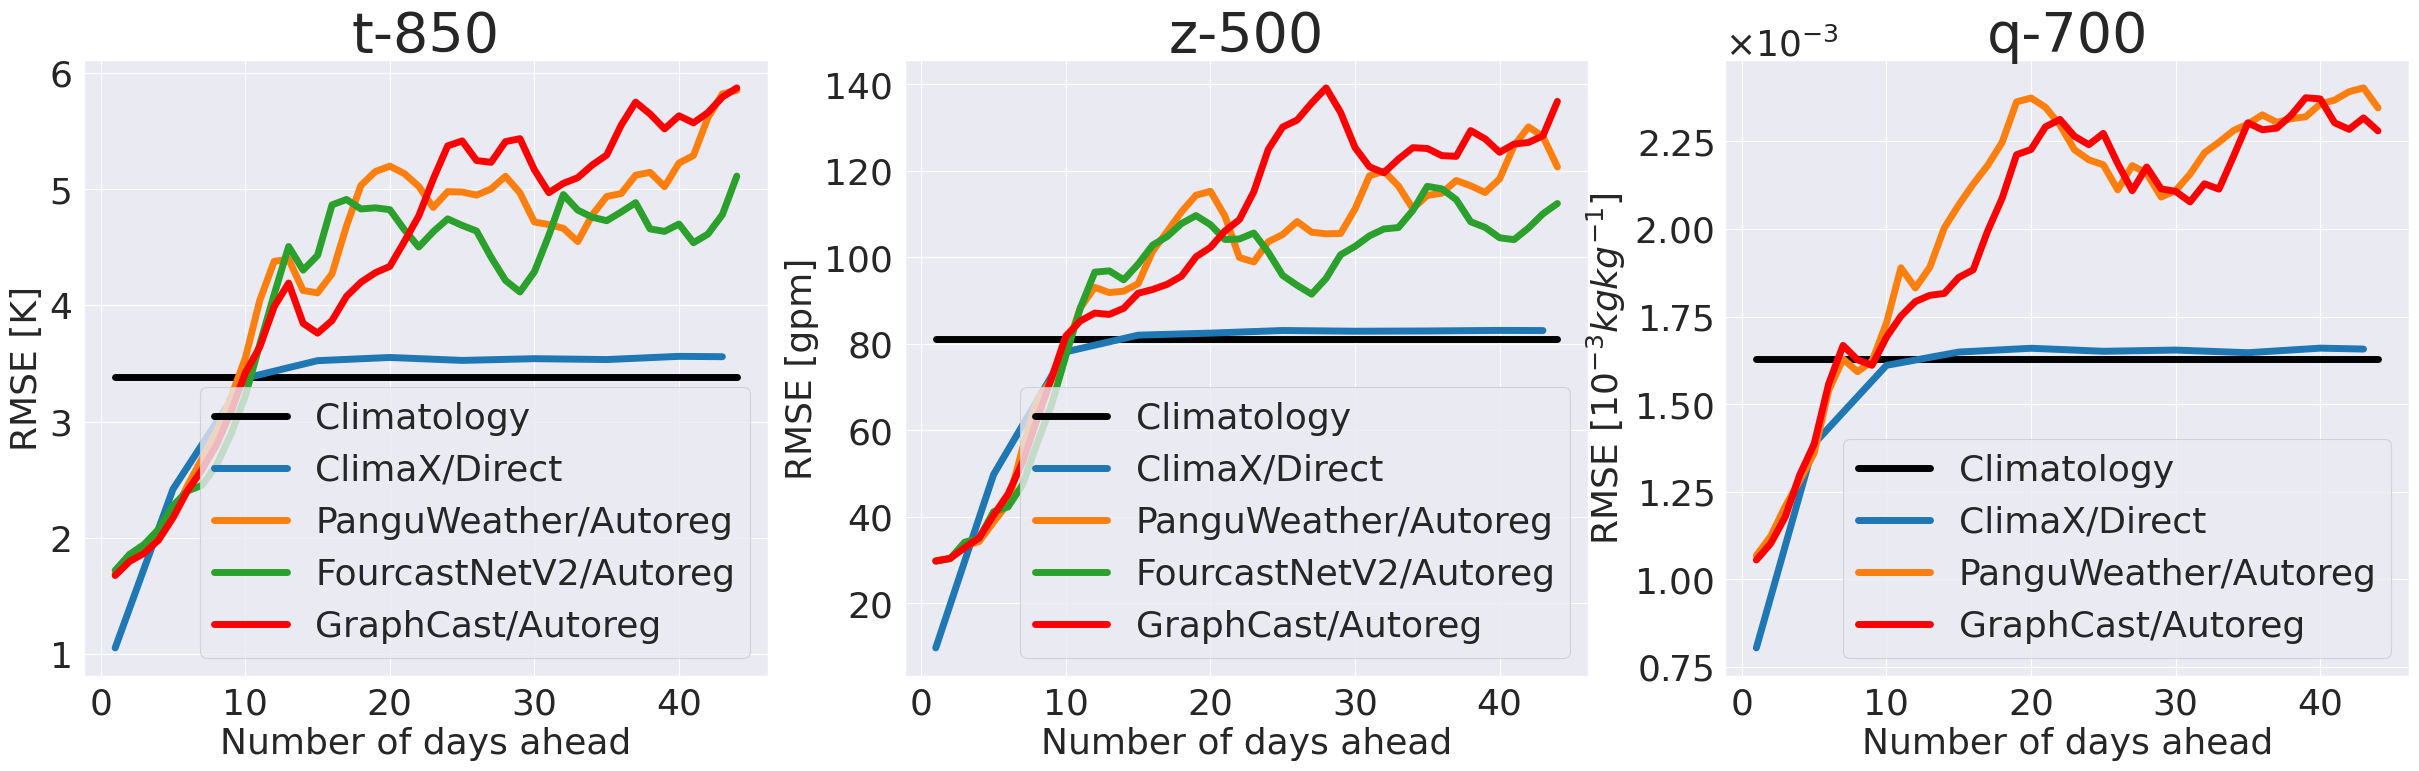

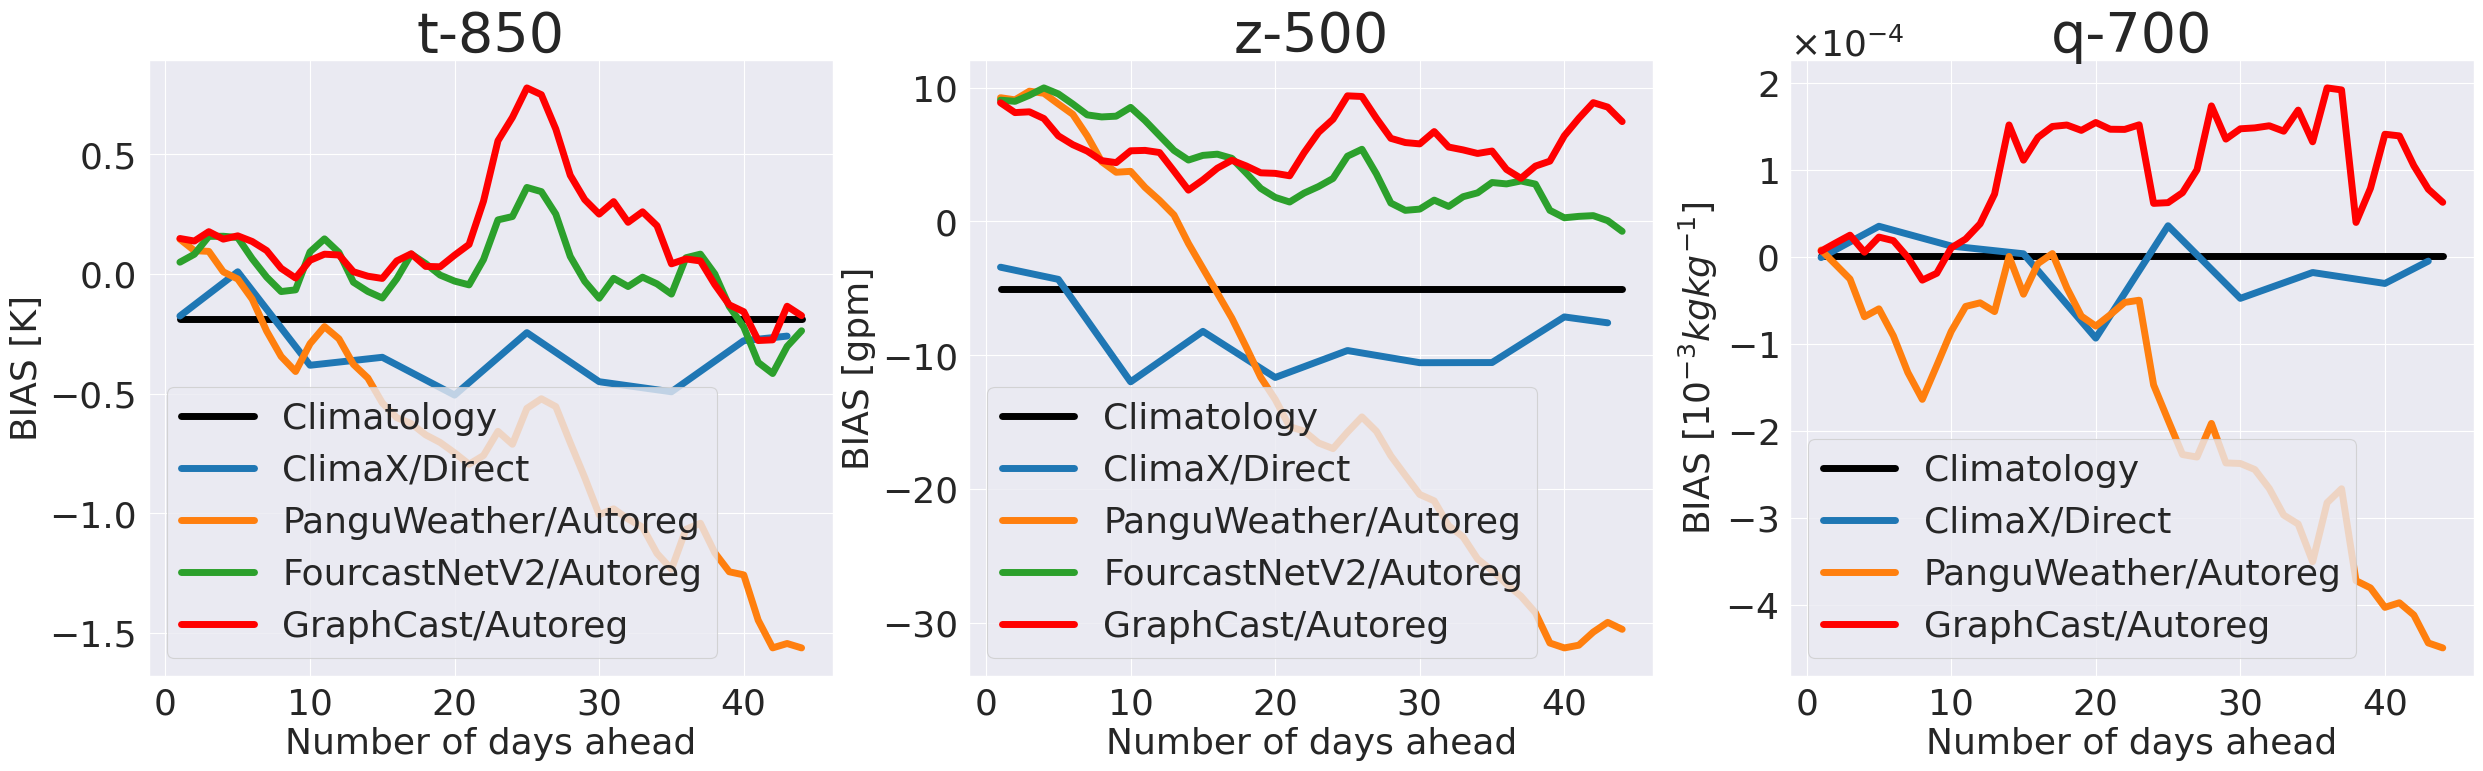

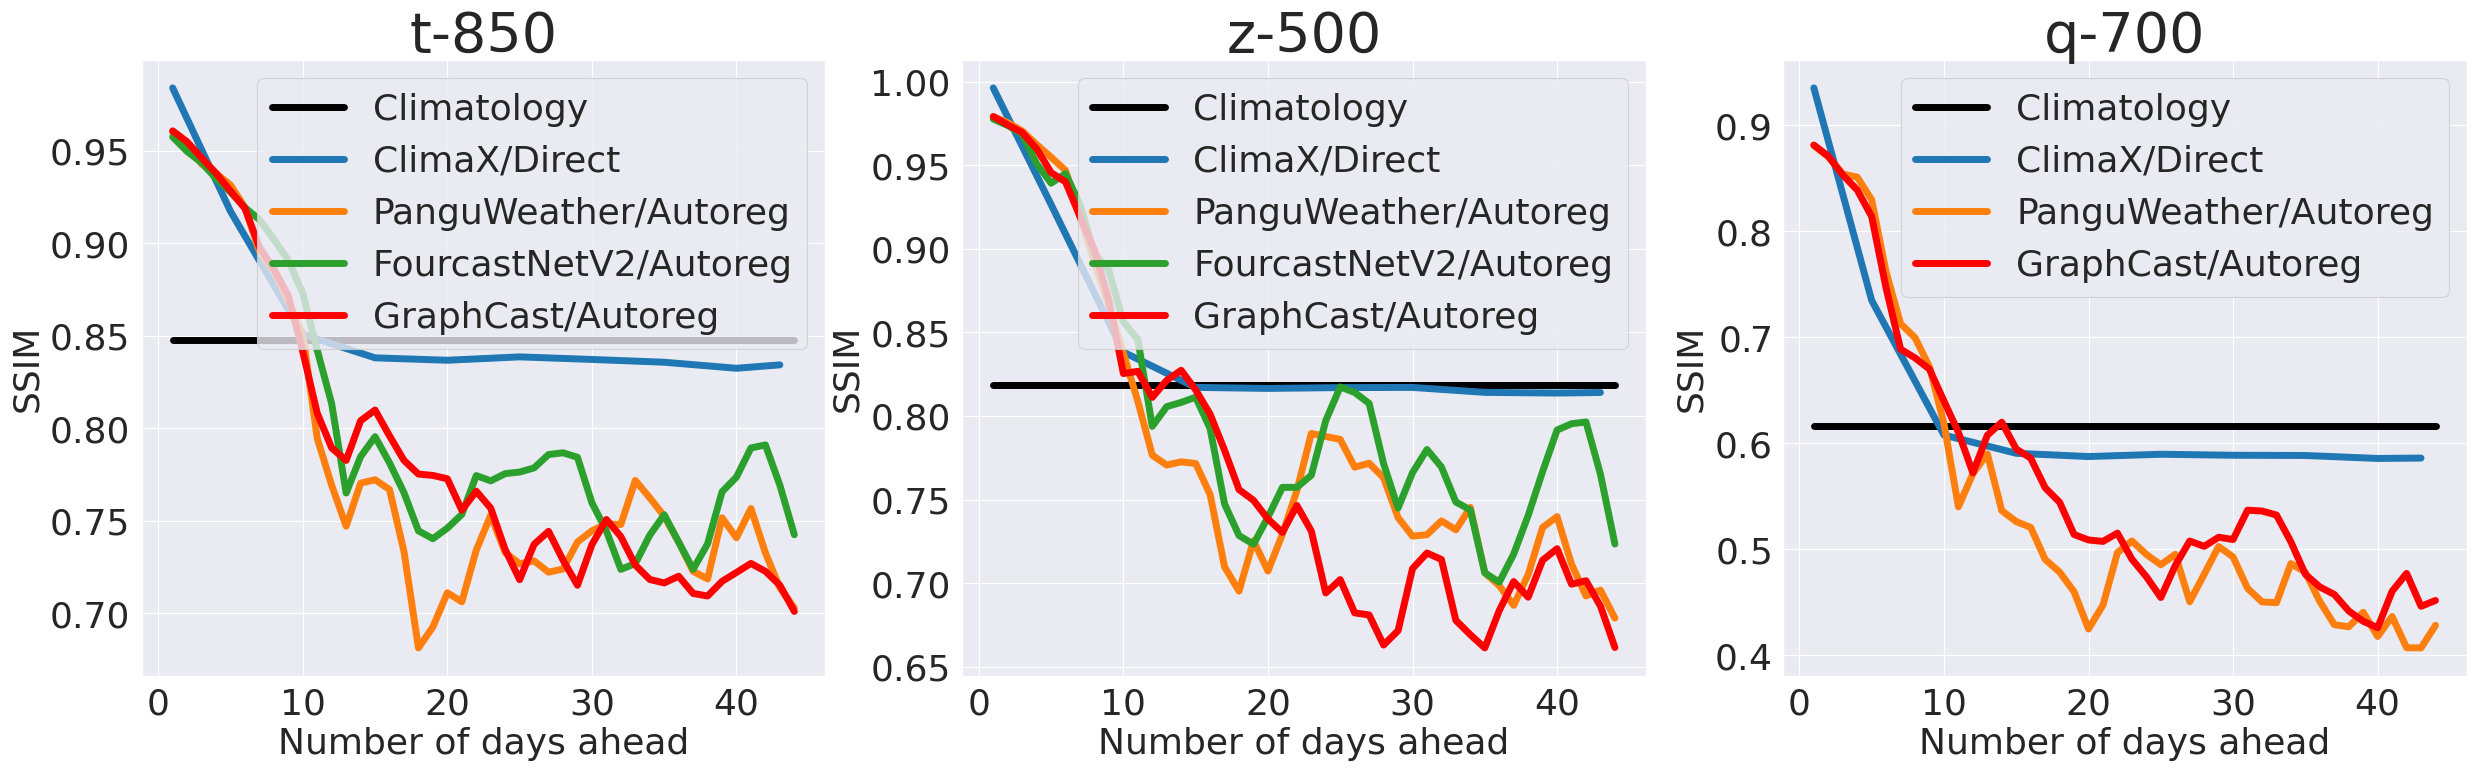

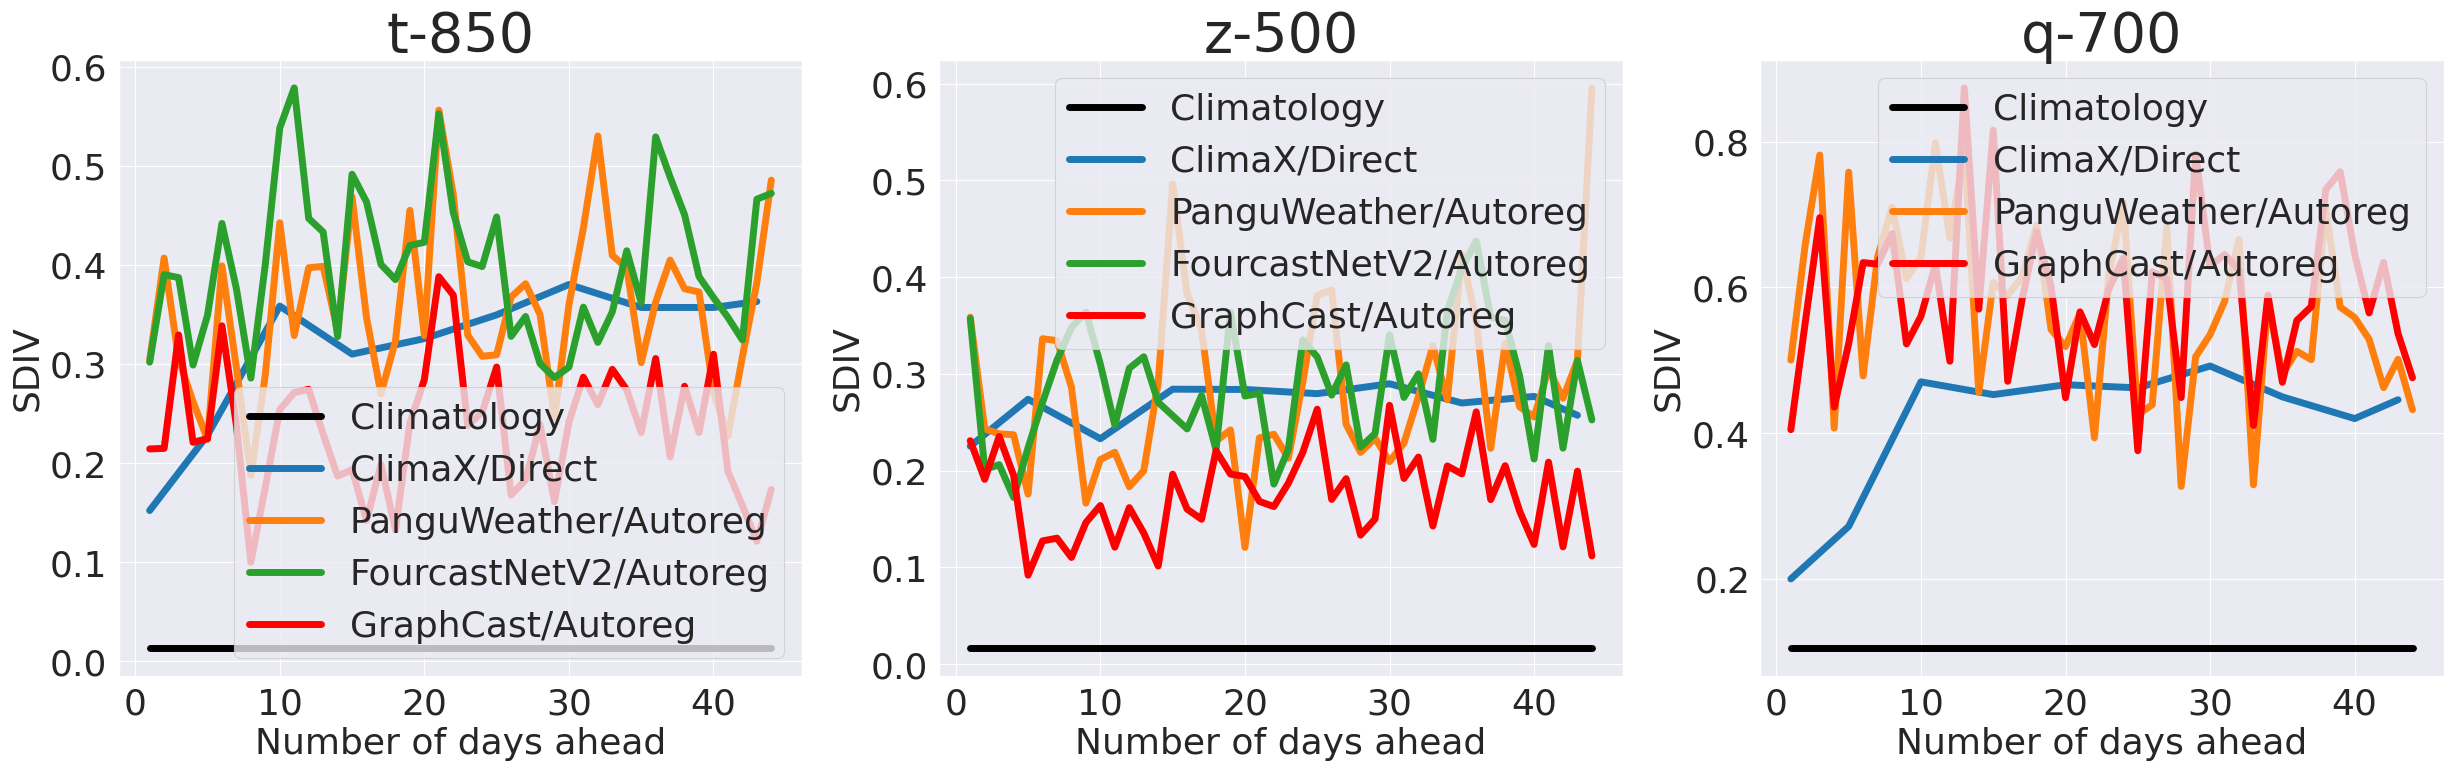

In [8]:
# Plot metrics over time, across direct vs autoregressive approaches
model_names = ['climatology', 'climax/direct_1', 'panguweather', 'fourcastnetv2', 'graphcast']
labels = ['Climatology', 'ClimaX/Direct', 'PanguWeather/Autoreg', 'FourcastNetV2/Autoreg', 'GraphCast/Autoreg']

for metric_idx, metric in enumerate(metrics):
    f, ax = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 8))
    
    for model_idx, model_name in enumerate(model_names):
        if 'climax' in model_name or 's2s' in model_name:
            model_basename, model_task = model_name.split('/')
            df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{model_task}/{metric}_{model_basename}.csv'))
        
        else:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            
            try:
                y = df[[headline_var]].to_numpy().squeeze()
                
                # Handling imputation of NaN values with 0.0
                if y.mean() == 0.0:
                    continue
                    
                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=labels[model_idx],
                    linewidth=5,
                    color=linecolors[model_idx],
                    ax=ax[headline_idx]
                )
            except:
                pass
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            
            if metric in ['acc', 'ssim', 'sdiv']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}', fontsize=40)
            
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2,2))  # Adjust the range for scientific notation
        plt.gca().yaxis.set_major_formatter(formatter)        
            
    plt.show();
    f.savefig(f'../docs/all_{metric}_time.pdf', dpi=200, bbox_inches='tight');


## Prediction visualization

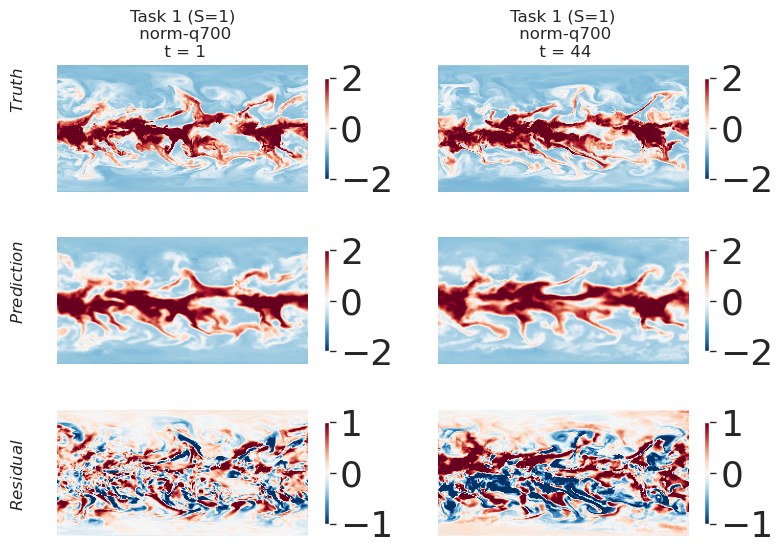

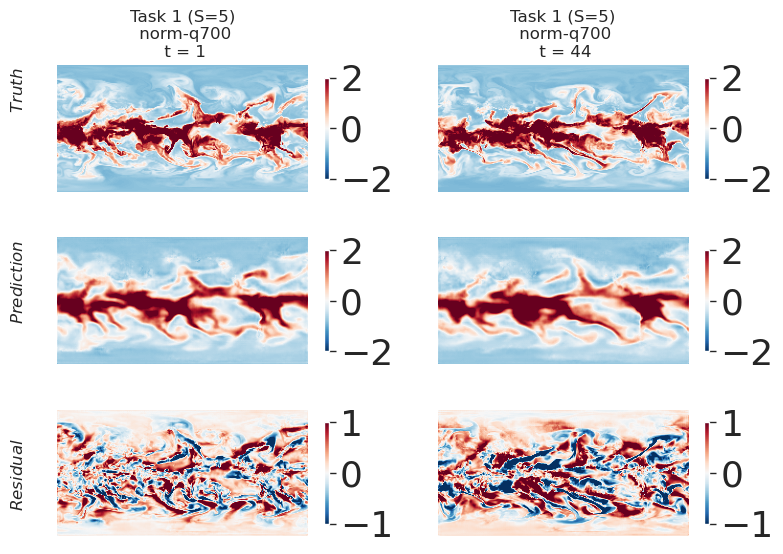

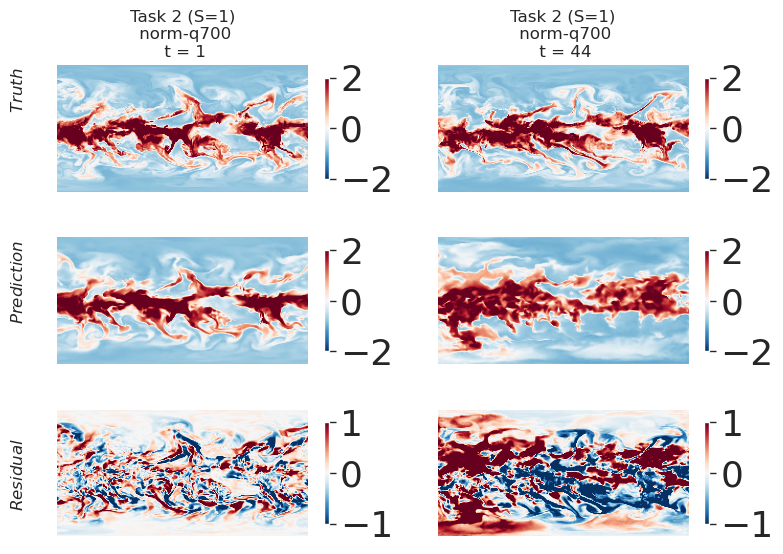

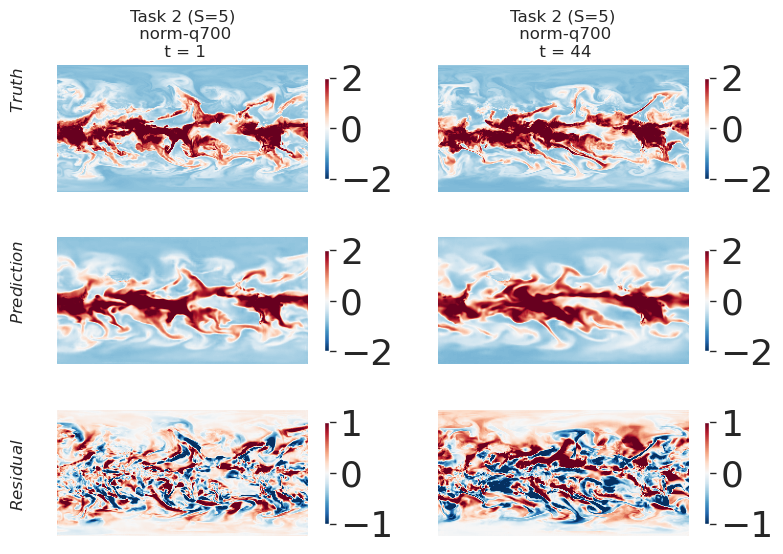

In [6]:
#################### CHANGE THIS ####################
date_idx = 0
param = 'q'
level = 700
model_name = 'unet_s2s'

plot_idx = [1, config.N_STEPS - 1]
######################################################

## Dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)


## Load config filepath which consists of all the definition needed to fit/eval a model
log_dir = Path('../logs') / model_name
model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

## Checkpointing
versions = ['version_0', 'version_1', 'version_2', 'version_3']

for version in versions:
    all_preds = list()
    all_truth = list()
    
    S = 'S=1' if (('0' in version) or ('2' in version)) else 'S=5'
    task = 'Task 1' if (('0' in version) or ('1' in version)) else 'Task 2'
    
    ckpt_filepath = log_dir / f'lightning_logs/{version}/checkpoints/'
    ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
    baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
    baseline = baseline.load_from_checkpoint(ckpt_filepath)
    
    with torch.no_grad():
    
        timestamp, input_x, input_y = input_dataset[date_idx]
        _, output_x, output_y = output_dataset[date_idx]

        curr_x = input_x.unsqueeze(0).to(device)

        for step_idx in range(config.N_STEPS - 1):
            preds = baseline(curr_x)
            curr_y = output_y.unsqueeze(0)[:, step_idx + 1]

            if step_idx + 1 in plot_idx:
                all_preds.append(preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
                all_truth.append(curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())

            curr_x = preds 
            
    # Plotting
    all_preds = np.array(all_preds)
    all_truth = np.array(all_truth)

    f, ax = plt.subplots(3, len(plot_idx), figsize=(8, 3 * len(plot_idx)))

    for time_idx in range(len(plot_idx)):

        im0 = ax[0, time_idx].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
        # ax[0, time_idx].set_title(f'Truth\n(step={plot_idx[time_idx]})')
        ax[0, time_idx].axis('off')
        cbar0 = f.colorbar(im0, ax=ax[0, time_idx], shrink=0.8)

        im1 = ax[1, time_idx].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
        # ax[1, time_idx].set_title(f'Prediction\n(step={plot_idx[time_idx]})')
        ax[1, time_idx].axis('off')
        cbar1 = f.colorbar(im1, ax=ax[1, time_idx], shrink=0.8)

        im2 = ax[2, time_idx].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
        # ax[2, time_idx].set_title(f'Residual\n(step={plot_idx[time_idx]})')
        ax[2, time_idx].axis('off')
        cbar2 = f.colorbar(im2, ax=ax[2, time_idx], shrink=0.8)

    # Adding titles for each row
    titles = [r'$Truth$', r'$Prediction$', r'$Residual$']
    for idx, title in enumerate(titles):
        f.text(-0.01, 0.82 - idx*0.32, title, va='center', ha='left', fontsize=12, rotation=90)

    ax[0,0].set_title(f'{task} ({S})\n norm-{param}{level}\n t = 1', fontsize=12)
    ax[0,1].set_title(f'{task} ({S})\n norm-{param}{level}\n t = 44', fontsize=12)
    plt.tight_layout()
    plt.show()
    f.savefig(f'../docs/preds_{model_name}_{param}{level}_{S}_{task}.pdf', dpi=200, bbox_inches='tight');


## Power spectrum

In [42]:
#################### CHANGE THIS ####################
date_idx = 0
n_steps = [0, 43]
model_type = 'fno'
task = 2
######################################################

param_levels = [['t', 850], ['z', 500], ['q', 700]]

if task == 1:
    model_list = [
        dict({f'Task_{task}/S=1': f'{model_type}_s2s/version_0', 
              f'Task_{task}/S=5': f'{model_type}_s2s/version_1'}), # task 1
    ]
    
else:
    model_list = [
        dict({f'Task_{task}/S=1': f'{model_type}_s2s/version_2', 
              f'Task_{task}/S=5': f'{model_type}_s2s/version_3'}), # task 2
    ]

Processing Task_2/S=1
Processing Task_2/S=5
Processing Task_2/S=1
Processing Task_2/S=5
Processing Task_2/S=1
Processing Task_2/S=5


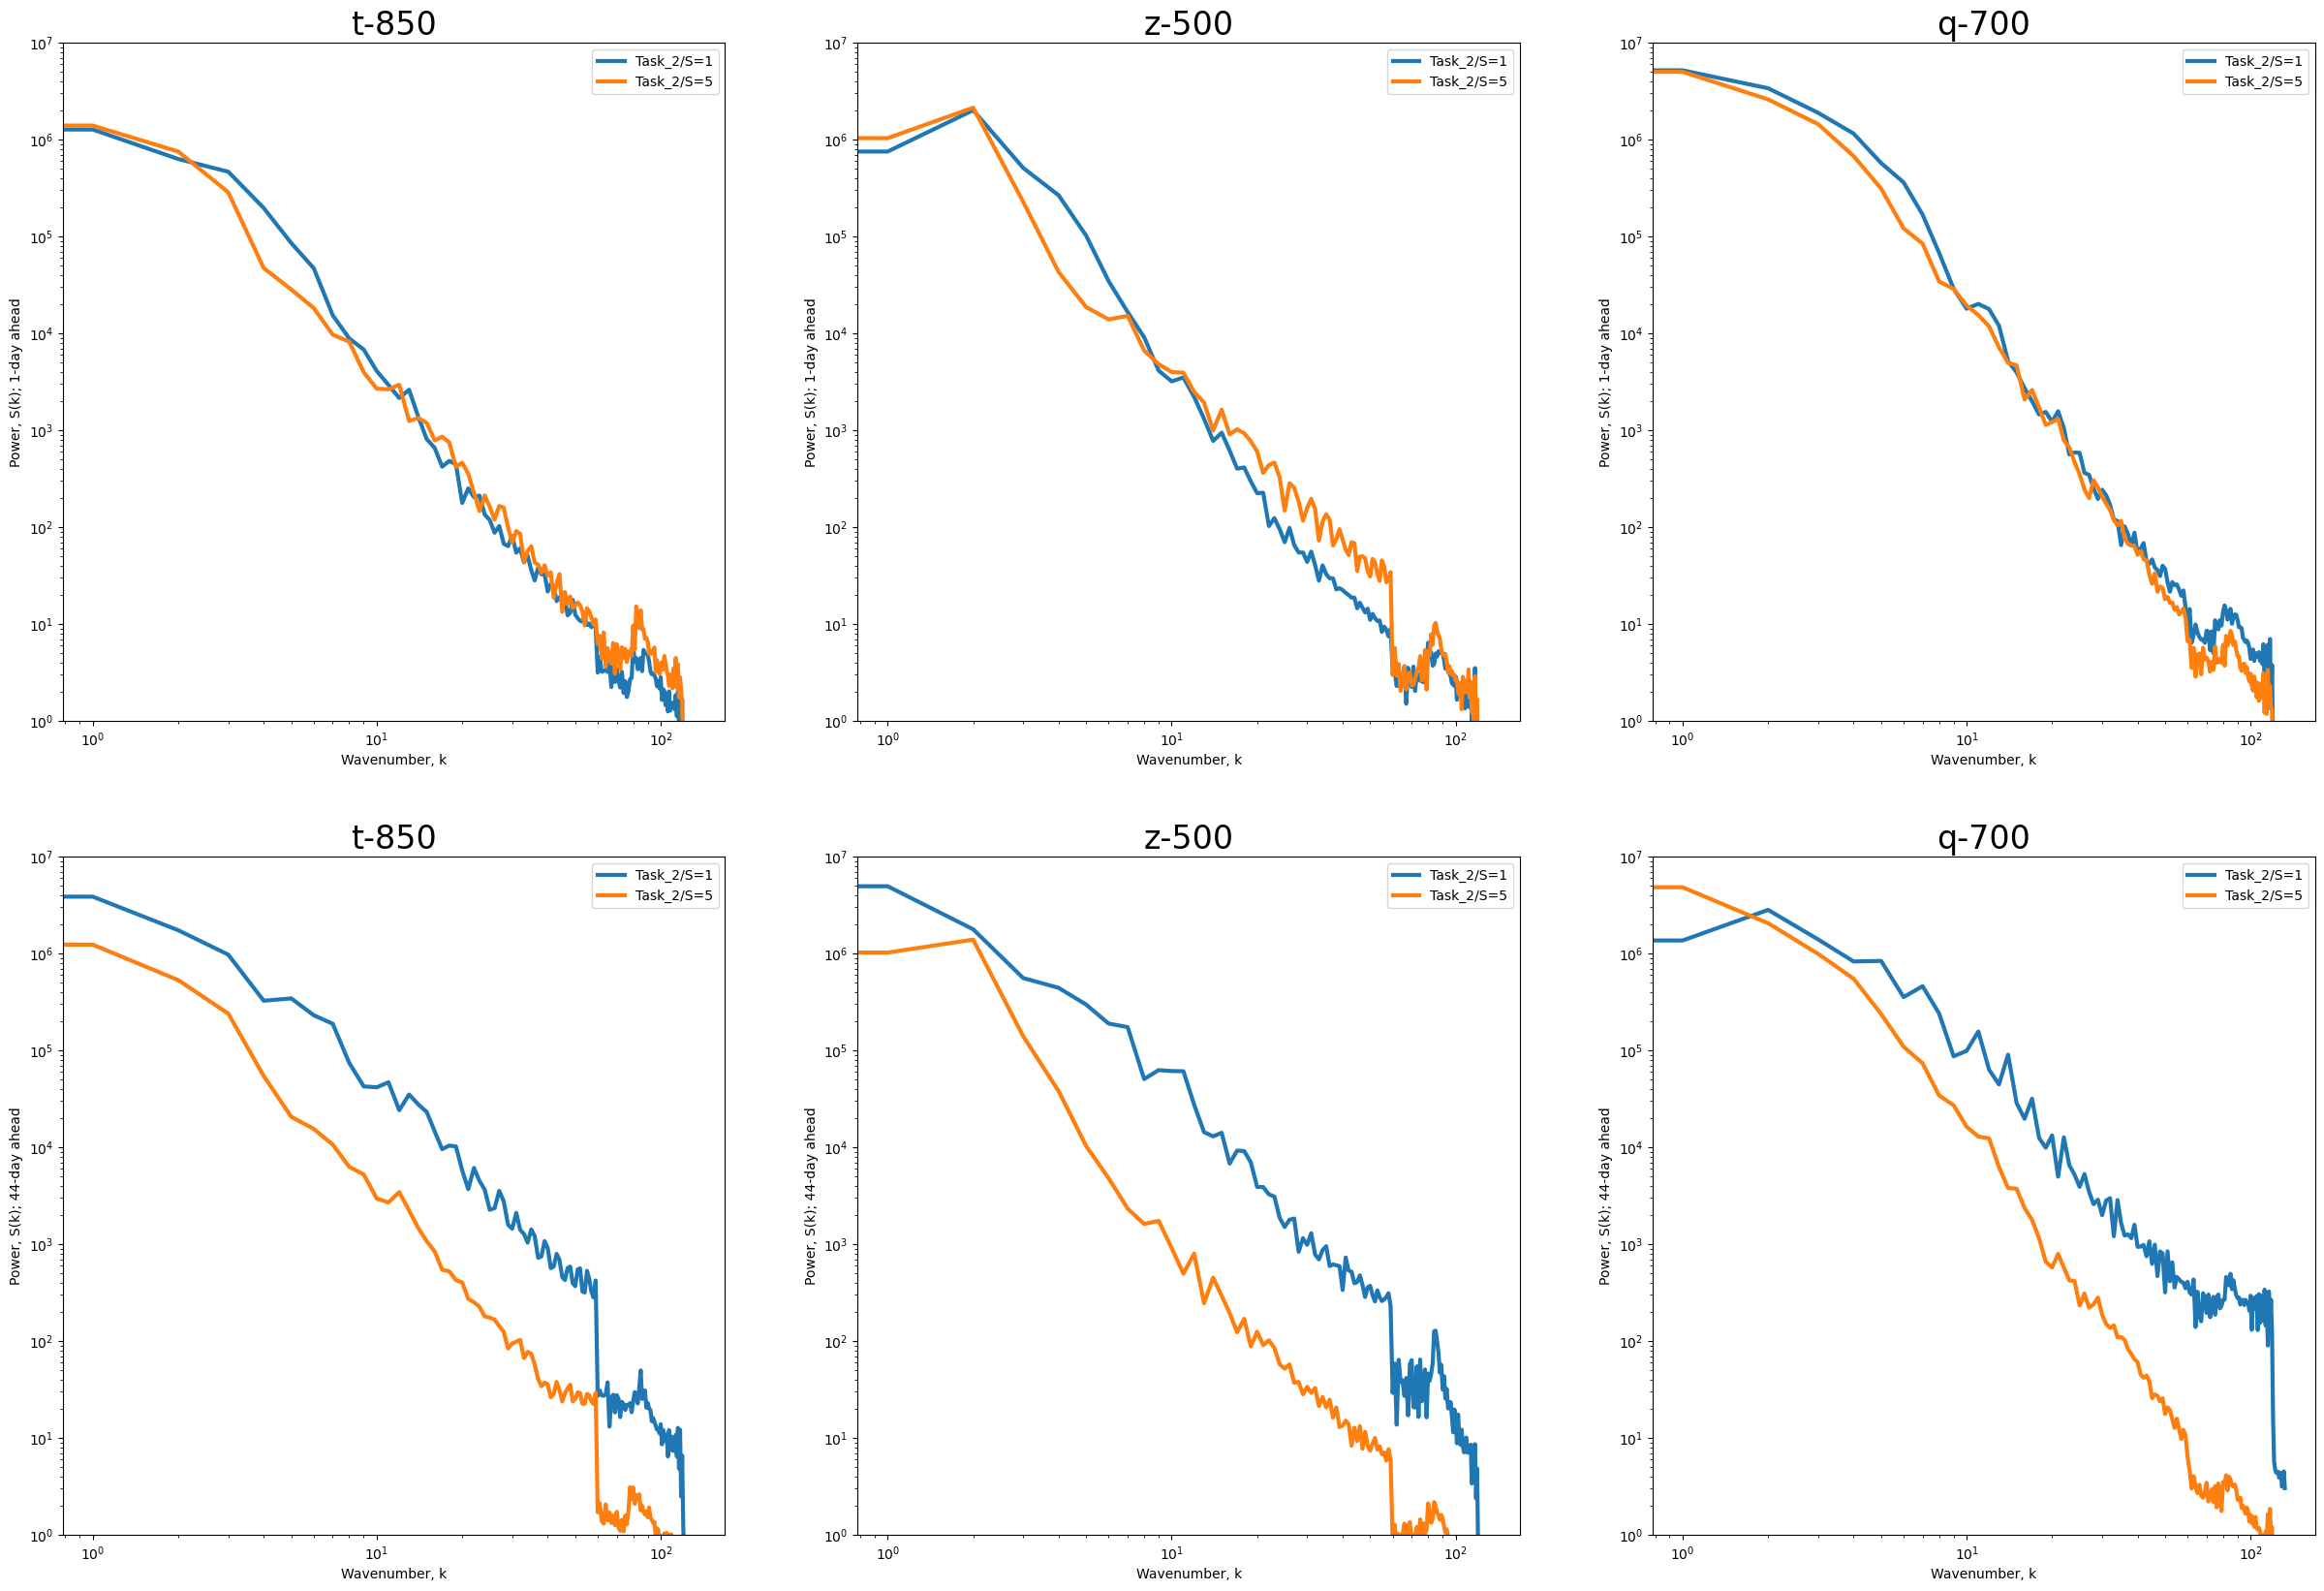

In [43]:
# Plot individual spectra at t=1 and t=44
all_Sk = dict()

## Initialize dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

# Compute power spectrum for each model and its configuration
f, ax = plt.subplots(len(n_steps), len(param_levels), figsize=(10*len(param_levels), 10*len(n_steps)))


for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    for model_item in model_list:

        for _, (model_spec, model_name) in enumerate(model_item.items()):
            print(f'Processing {model_spec}')

            all_preds, all_truth = list(), list()

            model_basename, model_version = model_name.split('/')

            log_dir = Path('../logs') / model_basename
            model_config_filepath = Path(f'../chaosbench/configs/{model_basename}.yaml')

            with open(model_config_filepath, 'r') as config_filepath:
                hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

            model_args = hyperparams['model_args']
            data_args = hyperparams['data_args']

            # Load checkpoints
            ckpt_filepath = log_dir / f'lightning_logs/{model_version}/checkpoints/'
            ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
            baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
            baseline = baseline.load_from_checkpoint(ckpt_filepath)

            with torch.no_grad():

                timestamp, input_x, input_y = input_dataset[date_idx]
                _, output_x, output_y = output_dataset[date_idx]

                curr_x = input_x.unsqueeze(0).to(device)

                for step_idx in range(config.N_STEPS - 1):
                    preds = baseline(curr_x)
                    curr_y = output_y.unsqueeze(0)[:, step_idx + 1]

                    all_preds.append(
                        preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()
                    )

                    all_truth.append(
                        curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()
                    )

                    curr_x = preds 

            all_preds, all_truth = np.array(all_preds), np.array(all_truth)


            # Plot power spectrum
            curr_pred_Sk, curr_truth_Sk = list(), list()

            for step_idx in range(all_preds.shape[0]):
                pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
                pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
                pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

                ny, nx = pred_t.shape
                kx = np.fft.fftfreq(nx) * nx
                ky = np.fft.fftfreq(ny) * ny

                kx, ky = np.meshgrid(kx, ky)
                k = np.sqrt(kx**2 + ky**2)

                k_bins = np.arange(0.5, np.max(k), 1)
                k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
                pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
                truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

                curr_pred_Sk.append(pred_Sk)
                curr_truth_Sk.append(truth_Sk)

                if step_idx in n_steps:
                    step_num = n_steps.index(step_idx)
                    ax[step_num, param_level_idx].set_title(f'{param}-{level}', fontsize=24)
                    ax[step_num, param_level_idx].loglog(pred_Sk, label=f'{model_spec}', linewidth=3)
                    ax[step_num, param_level_idx].set_xlabel('Wavenumber, k')
                    ax[step_num, param_level_idx].set_ylabel(f'Power, S(k); {step_idx + 1}-day ahead')
                    ax[step_num, param_level_idx].set_ylim([10**0, 10**7])
                    ax[step_num, param_level_idx].legend()

            all_Sk[f'{model_spec}:{param}-{level}'] = np.array(curr_pred_Sk)
            all_Sk['truth'] = np.array(curr_truth_Sk)

plt.show()
# f.savefig(f'../docs/specdiv_{model_type}_Task {task}.pdf', dpi=200, bbox_inches='tight');

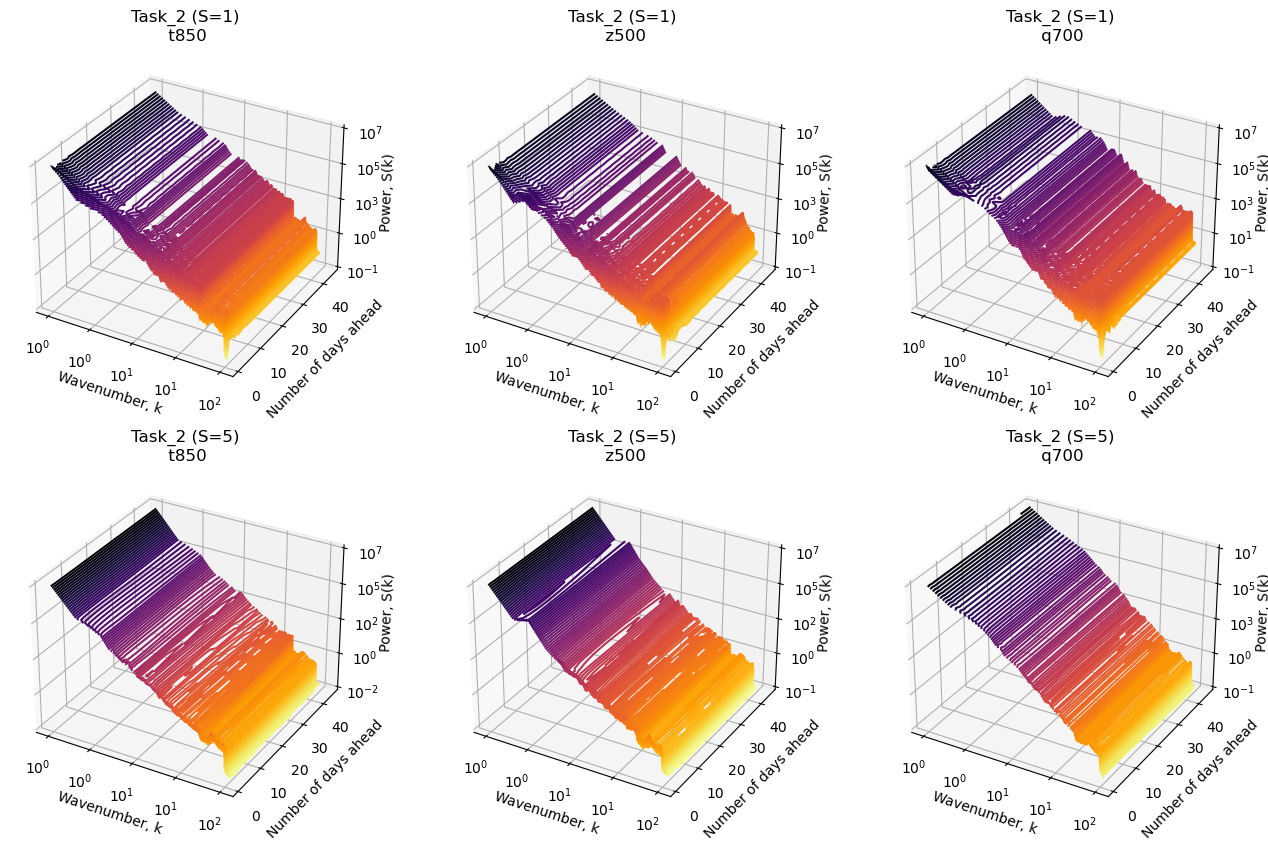

In [44]:
# Plot full power spectra
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def set_log_ticks_10_power(axis, num_ticks=5):
    lims = axis.get_data_interval()
    
    ticks = np.linspace(lims[0], lims[1], num=num_ticks)
    axis.set_ticks(ticks)
    axis.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in ticks])


eps = 1e-50 # to void log(0)
task_s = list(model_list[0].keys())
f = plt.figure(figsize=(16, 10))
subplot_idx = 1

for task_id, task in enumerate(task_s):
    task_num, step_size = task.split('/')
    
    for param_id, param_level in enumerate(param_levels):
        
        curr_Sk = all_Sk[f'{task}:{param_level[0]}-{param_level[1]}']
    
        # Plot the 3D contour plot
        ax = f.add_subplot(len(task_s), len(param_levels), subplot_idx, projection='3d')
        Wavenumber, Timestep = np.meshgrid(np.arange(1, curr_Sk.shape[1] + 1), np.arange(1, curr_Sk.shape[0] + 1))
        contour = ax.contour3D(np.log10(Wavenumber + eps), Timestep, np.log10(curr_Sk + eps), 100, cmap='inferno_r')

        ax.set_xlabel('Wavenumber, k')
        ax.set_ylabel('Number of days ahead')
        ax.set_zlabel(r'Power, S(k)', labelpad=0.1)

        set_log_ticks_10_power(ax.xaxis)
        set_log_ticks_10_power(ax.zaxis)
        
        ax.set_title(f'{task_num} ({step_size})\n {param_level[0]}{param_level[1]}', fontsize=12)
        subplot_idx += 1

plt.show()
f.savefig(f'../docs/3d_{model_type}_{task_num}.pdf', dpi=200, bbox_inches='tight');

## Effects of temporal information
For autoregressive approach...

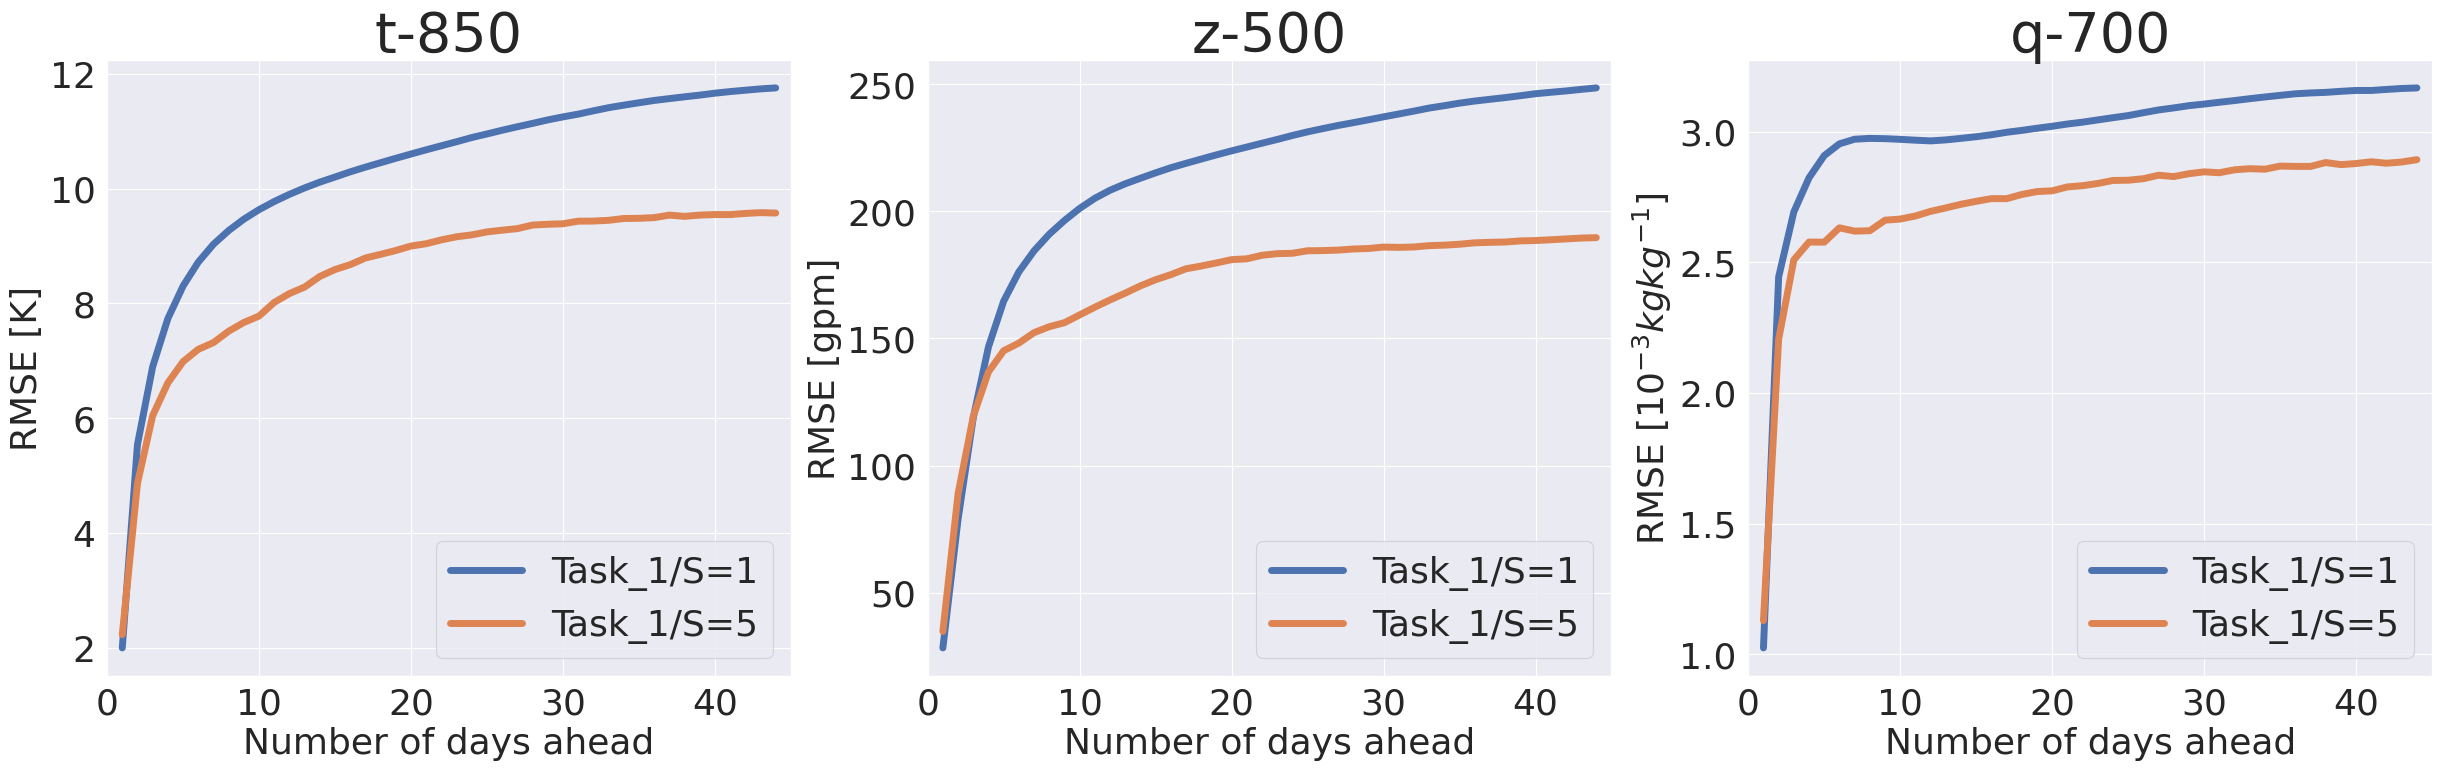

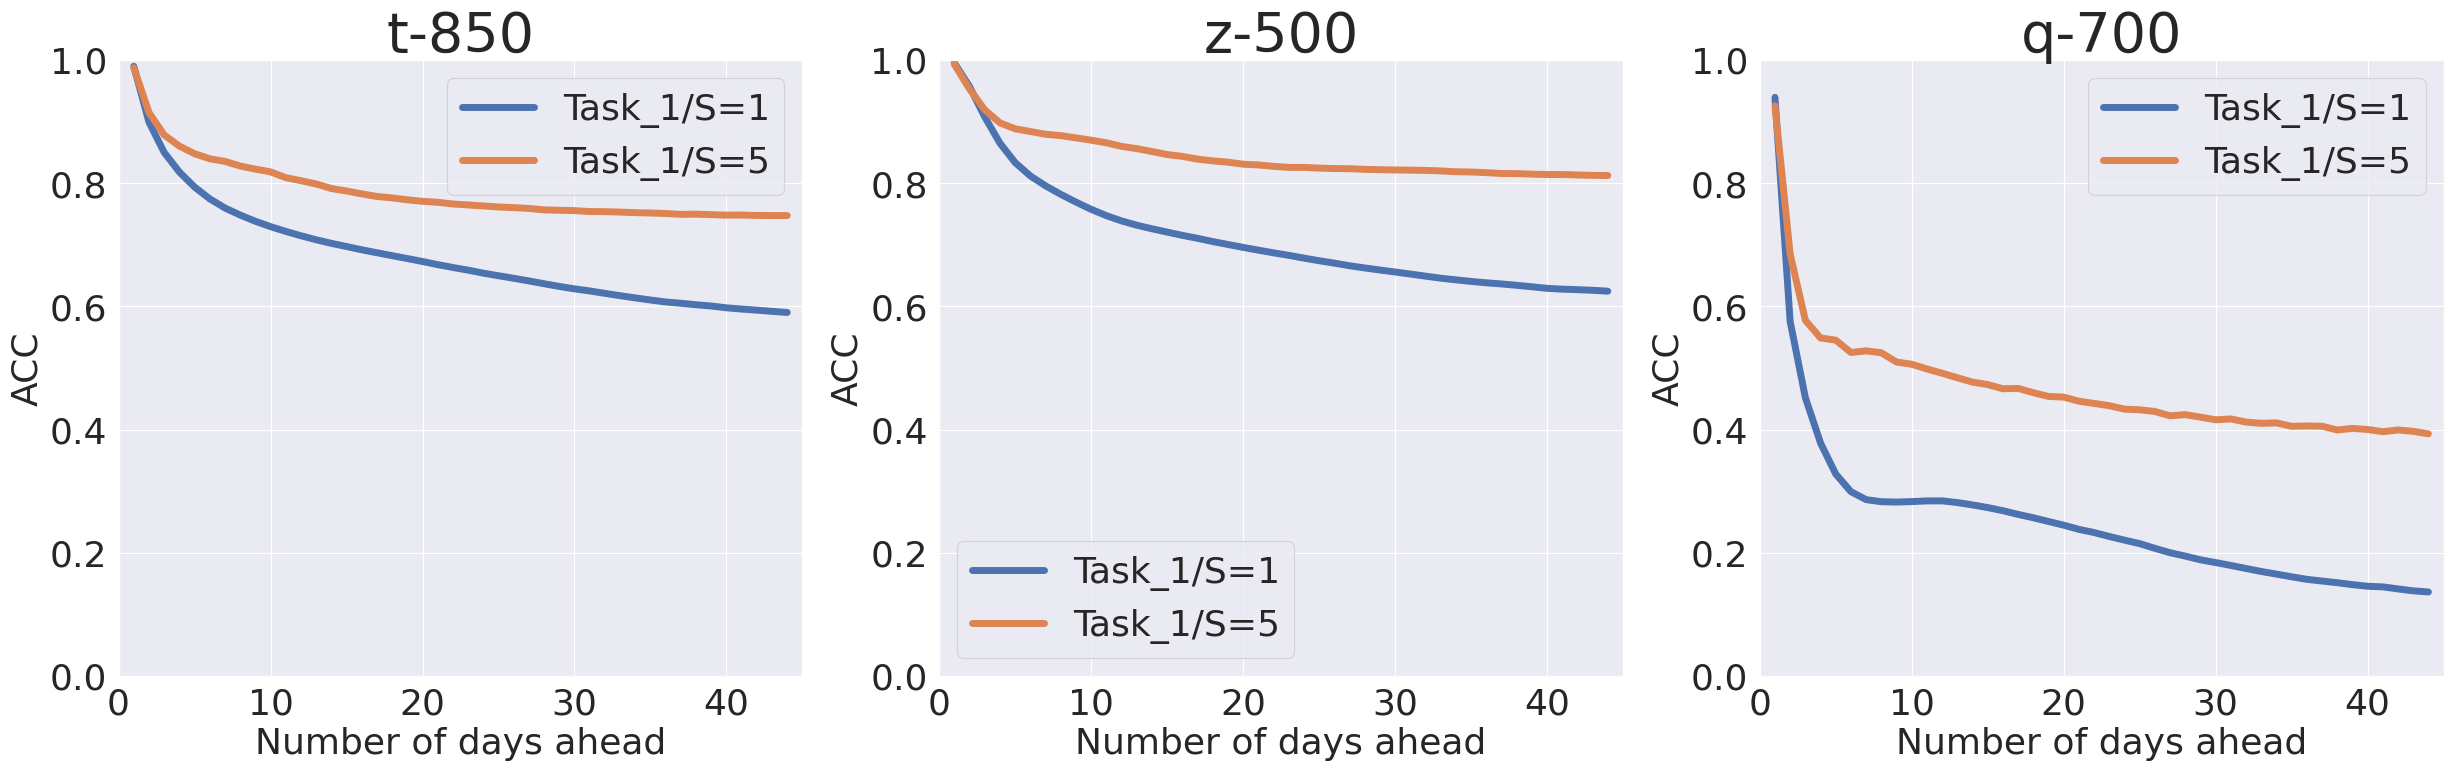

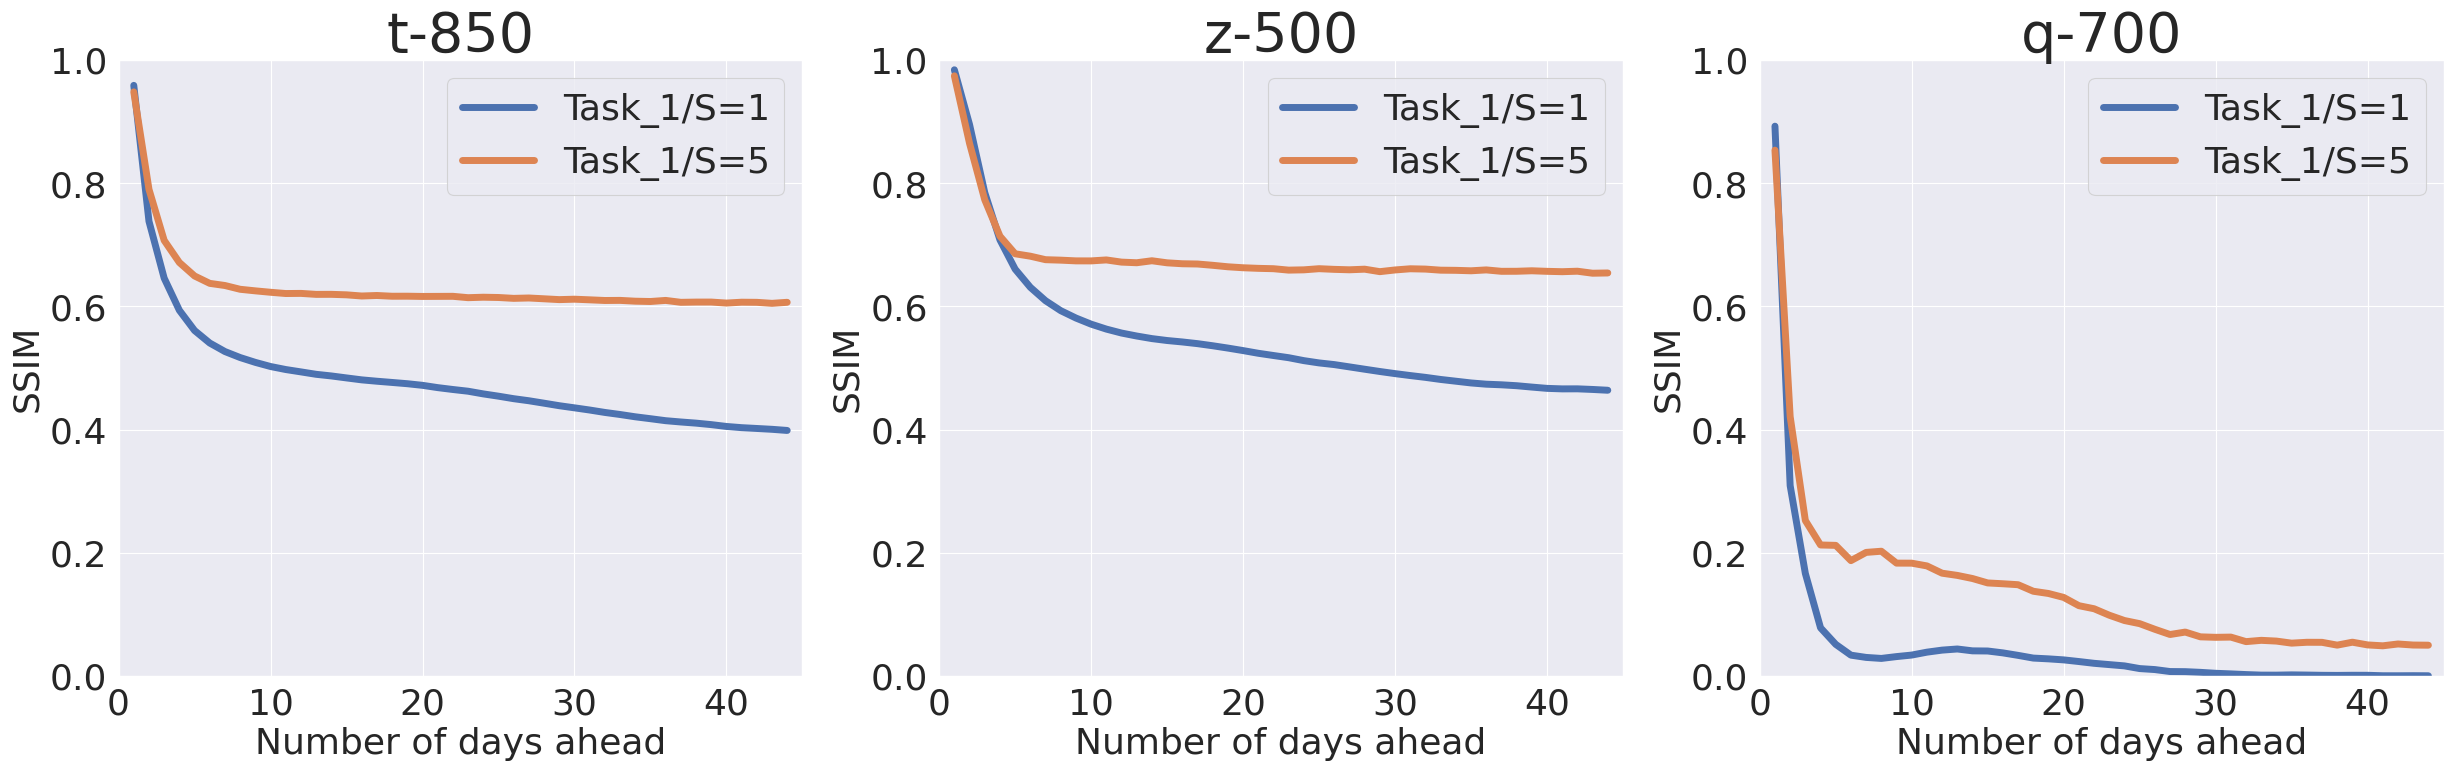

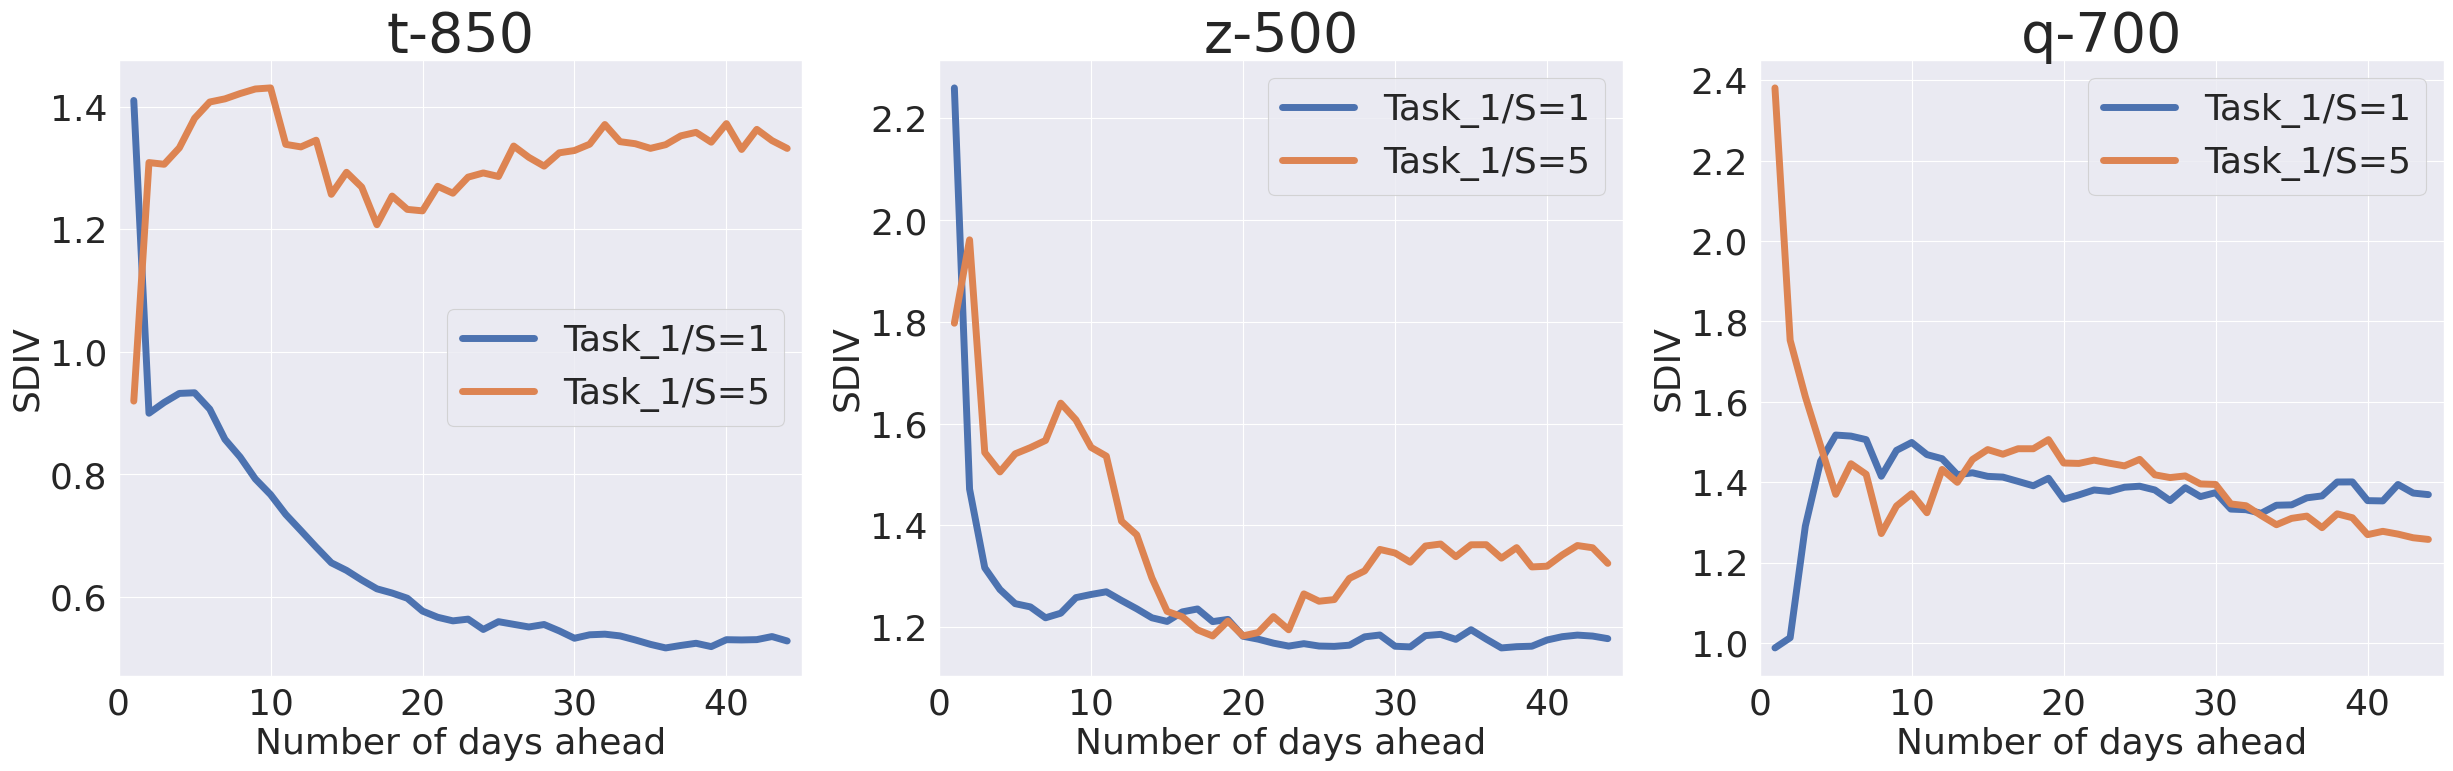

In [10]:
# Plot metrics over time, across tasks

model_list = [
    dict({'Task_1/S=1': 'unet_s2s/version_0', 'Task_1/S=5': 'unet_s2s/version_1'}), # task 1
    # dict({'Task_2/S=1': 'unet_s2s/version_2', 'Task_2/S=5': 'unet_s2s/version_3'}), # task 2
]

metrics = ['rmse', 'acc', 'ssim', 'sdiv']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$10^{-3}kg kg^{-1}$'})

for metric in metrics:
    
    f, ax = plt.subplots(1, len(headline_vars), figsize=(10*len(headline_vars), 8))
    
    for model_item in model_list:
    
        for model_idx, (model_spec, model_name) in enumerate(model_item.items()):
        
            model_basename, version_num = model_name.split('/')
            df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{version_num}/{metric}_{model_basename}.csv'))

            for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
                
                if 'q' in headline_var and metric == 'rmse':
                    y = df[[headline_var]].to_numpy().squeeze() * 1000 
                
                else:
                    y = df[[headline_var]].to_numpy().squeeze()

                sns.lineplot(
                    x=np.arange(1, df.shape[0]+1),
                    y=y, 
                    label=f'{model_spec}',
                    linewidth=5,
                    ax=ax[headline_idx]
                )

                ## Labeling
                ax[headline_idx].set_xlim([0,45])
                ax[headline_idx].set_xlabel('Number of days ahead')
                
                if metric == 'rmse':
                    ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
                    
                elif metric == 'sdiv':
                    ax[headline_idx].set_ylabel(f'{metric.upper()}')
                    
                else:
                    ax[headline_idx].set_ylabel(f'{metric.upper()}')
                    ax[headline_idx].set_ylim([0,1])
                    
                ax[headline_idx].set_title(f'{headline_var}', fontsize=40)
                
    f.savefig(f'../docs/autoreg_{metric}_task1.pdf', dpi=200, bbox_inches='tight');
            
plt.show()